In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedPiecewiseRationalQuadraticAutoregressiveTransform

from nflows.transforms.permutations import ReversePermutation

In [2]:
E0 = 500
R = 0.4

In [3]:
def target_p(x):

    mean = 0
    std = 1

    # Gaussian 
    p = 1/np.sqrt(2 * np.pi  * std**2) * np.exp(- (x - mean)**2 / 2 / std**2)
    return p



def Theta(x):
    return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def LO_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -torch.nan_to_num((2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * torch.log(lambda_ ) / lambda_ * Theta(1 - lambda_) * Theta(lambda_))

def LL_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return torch.nan_to_num(LO_angularity(lambda_, beta) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)) * Theta(1 - lambda_) * Theta(lambda_))


In [4]:
# Loss function
def calc_dkl(logp, logq, train_from_samples):


    if train_from_samples:
        return -(logp - logq).nanmean()# reverse KL, assuming samples from q
        
    else:
        return -(logp.exp()*(logq - logp)).nanmean()# reverse KL, assuming samples from q

In [5]:
base_dist = StandardNormal(shape=[1])

num_layers = 4
num_hidden_features = 128 # relaed to network width
num_blocks = 10 # related to network depth
num_bins = 10 # essentially how many piecewise splines we want
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=1))
    transforms.append(MaskedAffineAutoregressiveTransform(features=1, hidden_features = 128))
    # transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features = 1, 
    #                                   hidden_features = num_hidden_features, num_blocks = num_blocks, tail_bound = 5, 
    #                                               num_bins = num_bins, tails = "linear"))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters(), lr = 0.001)


In [6]:
from tqdm import tqdm

num_epochs = 200
train_losses = []

batch_size = 512

train_from_samples = False


def correct_f(z):
    return z*np.sqrt(sigmasq) + mean

def correct_f_inv(x):
    return (x - mean)/np.sqrt(sigmasq)

def correct_dx_dz(z):
    return np.sqrt(sigmasq)

def correct_dz_dx(x):
    return 1/np.sqrt(sigmasq)


t = tqdm(range(num_epochs))
for i in t:
    
    optimizer.zero_grad()
    
    if train_from_samples:
        
        # SAMPLE FROM THE PRIOR z
        z_samples = flow._distribution.sample(batch_size) 
        
        # APPLY FLOW TO PRIOR
        logp_of_z = flow._distribution.log_prob(z_samples)
        x_samples, log_dx_dz = flow._transform(z_samples)
        logq = logp_of_z - log_dx_dz
        

    else:
        
        # PULL VALUES OF x
        # x_samples = torch.linspace(-10, 10, steps = batch_size).reshape(-1,1)

        # Random uniform noise
        x_samples = torch.rand(batch_size, 1)
    
        # APPLY INVERSE FLOW TO x
        z_samples, log_dz_dx = flow._transform.inverse(x_samples)
        log_p_of_z = flow._distribution.log_prob(z_samples) 


        # # x_samples = torch.normal(mean, np.sqrt(sigmasq), (batch_size, 1))
        # z_samples = correct_f_inv(x_samples)
        # log_dz_dx = np.log(correct_dz_dx(x_samples))
        # log_p_of_z = flow._distribution.log_prob(z_samples) 




        # test_z = torch.rand(1000, 1)*20 - 10
        # test_x_samples = correct_f(test_z)
        # plt.plot(test_z.detach().numpy(), test_x_samples.detach().numpy(), 'o')
        # plt.plot(test_z, test_z*np.sqrt(sigmasq) + mean, 'r')

        logq = log_p_of_z + log_dz_dx
        logq = torch.reshape(logq, (-1, 1)) # KEY FIX FOR TRAINING ISSUE



        
        
    logp = torch.log(LL_angularity(x_samples))
    loss = calc_dkl(logp, logq, train_from_samples)

    print()
    print(logp)
    print(logq)
    print(loss)


    # plt.plot(x_samples.detach().cpu().numpy(), logq.detach().cpu().numpy(), 'o', alpha = 0.5)
    # plt.plot(x_samples.detach().cpu().numpy(), logp.detach().cpu().numpy(), 'x', alpha = 0.5)
    # plt.xlim(-5, 5)

    
    loss.backward()
    optimizer.step()
        
    train_losses.append(loss.detach().cpu().numpy())
    t.set_description('loss %.2f' % train_losses[-1])

    

  0%|          | 0/200 [00:00<?, ?it/s]

loss 0.64:   0%|          | 1/200 [00:00<00:44,  4.42it/s]


tensor([[-5.3133e-01],
        [-3.3689e+00],
        [-5.3272e+00],
        [-1.1404e-01],
        [-4.7034e+00],
        [ 1.5909e+00],
        [ 1.5430e+00],
        [ 4.0957e-01],
        [ 2.5521e-01],
        [-7.4831e-02],
        [-2.4511e+00],
        [-1.6270e+00],
        [-4.9535e+00],
        [-4.9283e+00],
        [ 1.4856e+00],
        [-2.4975e+00],
        [-8.0220e-01],
        [-3.1264e+00],
        [-4.3675e+00],
        [-2.2554e+00],
        [-7.8846e+00],
        [-1.5535e+00],
        [-3.7973e-01],
        [-3.3679e+00],
        [ 5.7108e-01],
        [-4.4845e+00],
        [-2.7872e+00],
        [-5.8872e-01],
        [-7.2186e-01],
        [ 6.9246e-01],
        [-1.7557e+00],
        [-5.3058e-01],
        [-2.2174e+00],
        [ 2.6546e-01],
        [-1.6277e-01],
        [-2.0453e+00],
        [ 4.0823e-01],
        [-1.2241e+00],
        [-7.2460e-01],
        [ 1.1802e+00],
        [-2.3585e+00],
        [ 5.7396e-01],
        [-2.2299e+00],
        [-

loss 1.51:   1%|          | 2/200 [00:00<00:42,  4.61it/s]

tensor([[ 1.5957],
        [-4.1572],
        [ 1.5453],
        [ 0.5516],
        [-3.2434],
        [-1.1788],
        [-0.5180],
        [-2.3338],
        [-1.1495],
        [-4.8967],
        [-0.2110],
        [-1.8480],
        [-3.4271],
        [ 0.0613],
        [-2.2705],
        [-2.4708],
        [-4.1398],
        [-1.7780],
        [-3.4153],
        [-2.3163],
        [-3.7729],
        [-2.6997],
        [ 1.3720],
        [-2.7003],
        [ 0.9757],
        [-2.0919],
        [-0.5238],
        [-2.0239],
        [ 1.5208],
        [-1.1471],
        [ 0.7759],
        [-2.6222],
        [-0.2102],
        [   -inf],
        [-0.1268],
        [-2.0617],
        [-3.2860],
        [-2.9649],
        [-3.5322],
        [-2.6688],
        [ 1.4404],
        [-0.8210],
        [-1.2963],
        [-2.0723],
        [ 0.5410],
        [-3.4095],
        [-2.0812],
        [-0.2359],
        [-2.7614],
        [-0.2927],
        [-0.9472],
        [-1.2656],
        [ 0.

loss 0.80:   2%|▏         | 3/200 [00:00<00:38,  5.17it/s]

tensor([[ 6.4039e-01],
        [ 1.5956e+00],
        [ 1.2394e+00],
        [-2.2596e+00],
        [-1.0181e+00],
        [-2.8535e+00],
        [-4.7746e+00],
        [-3.9867e-01],
        [ 1.1708e+00],
        [-2.0821e+00],
        [-1.0868e+00],
        [-1.4902e-01],
        [-3.5234e+00],
        [-5.0553e+00],
        [-4.4620e+00],
        [ 5.9187e-01],
        [-9.2265e-02],
        [-2.9007e-01],
        [-1.7185e+00],
        [-7.1792e-01],
        [-3.4289e+00],
        [-1.3989e+00],
        [-2.7962e+00],
        [-3.0866e-01],
        [-2.4651e+00],
        [-2.1867e+00],
        [-2.9374e+00],
        [-1.2431e+00],
        [-5.9506e-01],
        [-2.2854e+00],
        [-1.6902e+00],
        [-4.2528e+00],
        [-1.3733e+00],
        [-1.2064e+00],
        [-1.7785e+00],
        [-3.0867e+00],
        [-3.4126e-01],
        [ 5.8908e-01],
        [ 2.2726e-01],
        [-1.5490e+00],
        [ 1.4908e+00],
        [-3.3443e+00],
        [ 4.3372e-01],
        [-8

loss 0.43:   2%|▏         | 4/200 [00:00<00:47,  4.15it/s]

tensor([[ 1.4948e-01],
        [ 1.4726e-01],
        [-2.0255e+00],
        [-1.3807e+00],
        [-2.5779e-02],
        [-3.0992e+00],
        [-3.4763e-02],
        [-3.2004e+00],
        [ 7.8484e-02],
        [-1.4543e+00],
        [-8.1395e-01],
        [-1.3059e+00],
        [ 1.5141e-01],
        [-1.5160e+00],
        [-1.4149e+00],
        [-6.8756e-01],
        [ 1.5195e-01],
        [-5.2568e-01],
        [-4.1496e-01],
        [ 1.4031e-01],
        [-1.4943e+00],
        [ 3.7202e-02],
        [ 1.5195e-01],
        [-3.2791e+00],
        [-1.1511e+00],
        [-3.6536e-01],
        [-8.1958e-01],
        [-1.1905e+00],
        [-1.2839e-01],
        [ 1.4634e-01],
        [-5.6168e-01],
        [-6.4663e-01],
        [-2.5209e-01],
        [-1.6947e-01],
        [-1.8936e+00],
        [ 1.4698e-01],
        [-1.3522e+00],
        [ 1.0803e-01],
        [-3.3030e-01],
        [ 2.3728e-02],
        [ 1.2187e-01],
        [-2.3301e+00],
        [ 1.3809e-01],
        [ 1

loss -0.00:   2%|▎         | 5/200 [00:01<00:48,  4.05it/s]


tensor([[-1.6588e+00],
        [-1.4888e+00],
        [-4.3119e+00],
        [ 6.6937e-01],
        [ 1.4598e+00],
        [ 1.3978e+00],
        [-4.7218e-01],
        [-4.3297e-01],
        [-5.0106e+00],
        [-6.7480e-01],
        [-5.9233e+00],
        [-2.5779e+00],
        [-1.0070e+00],
        [-2.7908e+00],
        [-1.7621e+00],
        [-2.2424e+00],
        [-1.8472e+00],
        [-2.3750e+00],
        [ 4.5818e-01],
        [-6.0812e+00],
        [-2.4077e+00],
        [-2.2717e+00],
        [-1.1297e+00],
        [ 1.4495e+00],
        [-1.6085e+00],
        [ 1.1097e+00],
        [-1.4131e+00],
        [-9.1280e-01],
        [ 3.8525e-02],
        [ 1.3552e+00],
        [-1.1135e+00],
        [-3.3437e+00],
        [ 3.3005e-01],
        [-4.9660e-01],
        [ 1.1513e+00],
        [-3.7066e+00],
        [ 1.5538e+00],
        [ 1.1346e-01],
        [-6.8278e-01],
        [ 2.7945e-01],
        [-3.1499e+00],
        [ 1.2215e+00],
        [-1.5197e+00],
        [-

loss -0.00:   4%|▎         | 7/200 [00:01<01:06,  2.90it/s]


tensor([[ 1.4933e+00],
        [ 2.5070e-01],
        [-1.8407e+00],
        [-2.7354e+00],
        [ 1.1749e+00],
        [-1.5477e+00],
        [ 1.2545e+00],
        [ 9.6559e-01],
        [-1.3151e+00],
        [-2.7162e+00],
        [-1.1890e+00],
        [-3.5299e+00],
        [-2.7580e+00],
        [-2.3914e+00],
        [-6.2461e+00],
        [-2.8723e+00],
        [-1.2534e+00],
        [-3.7915e+00],
        [-1.2217e+00],
        [-3.2438e+00],
        [-1.2606e+00],
        [-2.8215e+00],
        [-2.3019e+00],
        [-3.1489e+00],
        [-1.7389e+00],
        [ 1.0082e+00],
        [-1.6393e+00],
        [-5.0148e+00],
        [-2.1884e+00],
        [-1.2441e+00],
        [-1.9457e+00],
        [ 2.4319e-01],
        [-5.1767e+00],
        [-6.2477e-01],
        [ 1.5366e+00],
        [-3.1688e+00],
        [ 3.0297e-01],
        [-4.9905e+00],
        [-2.0706e+00],
        [-1.3964e-01],
        [-4.7287e-01],
        [ 6.0125e-01],
        [-2.7385e+00],
        [-

loss -0.00:   4%|▍         | 8/200 [00:02<01:00,  3.16it/s]


tensor([[-3.9615e+00],
        [ 1.5933e+00],
        [-9.6337e-01],
        [ 9.7898e-01],
        [-2.1645e+00],
        [-2.3545e+00],
        [ 1.0987e+00],
        [-4.7674e-01],
        [-3.4272e-01],
        [-3.4422e+00],
        [ 9.2261e-01],
        [ 1.3576e-01],
        [-1.4047e+00],
        [-4.3542e-01],
        [-6.7774e-01],
        [-2.5239e+00],
        [-5.4528e-01],
        [-2.9526e+00],
        [-4.8108e+00],
        [-4.3802e+00],
        [ 8.0128e-01],
        [-1.4909e+00],
        [-8.1567e-02],
        [-1.1166e+00],
        [-1.5156e+00],
        [-2.3026e+00],
        [-2.2689e+00],
        [ 1.0228e+00],
        [-2.8548e+00],
        [-1.6460e+00],
        [-2.7336e+00],
        [-7.6484e-01],
        [-1.0854e+00],
        [ 5.0893e-01],
        [-2.8586e+00],
        [-1.9483e+00],
        [-8.3568e-01],
        [ 1.4843e+00],
        [ 1.5372e-01],
        [-2.1381e+00],
        [ 9.3536e-01],
        [-1.2970e+00],
        [-9.4829e-01],
        [-

loss -0.00:   4%|▍         | 9/200 [00:02<00:51,  3.68it/s]


tensor([[-1.5672e+00],
        [-2.1377e-01],
        [-1.6973e+00],
        [-1.0422e+00],
        [-3.3387e+00],
        [-5.5645e+00],
        [-1.3756e+00],
        [-6.0687e-01],
        [-1.8002e+00],
        [-7.4994e-01],
        [-5.1343e-01],
        [-2.1368e+00],
        [-2.0987e+00],
        [-5.6125e+00],
        [-1.3498e+00],
        [ 1.0975e+00],
        [ 1.1458e+00],
        [-3.7456e+00],
        [-4.1895e+00],
        [-8.0945e-01],
        [-3.1485e+00],
        [-3.1562e+00],
        [ 7.8286e-01],
        [-2.7563e+00],
        [-3.5336e+00],
        [-6.3902e-01],
        [-2.1918e+00],
        [-1.4528e+00],
        [-2.4731e+00],
        [-1.3107e+00],
        [-2.1374e+00],
        [-1.3249e+00],
        [-3.3043e+00],
        [-9.9553e-01],
        [-2.4864e+00],
        [ 1.5909e+00],
        [-2.4708e+00],
        [ 1.5956e+00],
        [-4.0590e-01],
        [-3.0925e+00],
        [-2.8657e+00],
        [-3.4700e+00],
        [-1.4207e+00],
        [-

loss -0.00:   5%|▌         | 10/200 [00:02<00:46,  4.12it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:   6%|▌         | 11/200 [00:03<01:10,  2.69it/s]


tensor([[ 8.1249e-01],
        [-1.4310e+00],
        [ 2.9974e-01],
        [-3.3611e+00],
        [ 1.4562e+00],
        [ 1.1236e+00],
        [-7.8489e-01],
        [-1.4736e+00],
        [-1.3391e+00],
        [-1.3080e+00],
        [-1.1399e+00],
        [-2.7969e+00],
        [-2.6041e+00],
        [-2.5650e+00],
        [-1.4438e+00],
        [-1.1930e+00],
        [ 5.2689e-01],
        [-6.4653e+00],
        [-2.7110e+00],
        [ 2.8048e-01],
        [ 9.4767e-01],
        [-4.0328e+00],
        [-3.3108e-01],
        [-1.6659e-01],
        [-8.3221e-01],
        [-1.9454e+00],
        [-2.1783e+00],
        [-8.0913e-01],
        [ 5.0369e-01],
        [-1.5384e+00],
        [-2.5184e+00],
        [ 9.0203e-01],
        [-3.8211e+00],
        [-1.2034e+00],
        [ 1.3435e+00],
        [ 7.7359e-01],
        [-5.2682e-01],
        [-3.2702e+00],
        [-3.1451e+00],
        [ 2.3651e-02],
        [-5.7159e-01],
        [ 5.8767e-01],
        [ 1.2810e+00],
        [-

loss -0.00:   6%|▌         | 12/200 [00:03<01:02,  3.00it/s]


tensor([[-2.4338e+00],
        [-2.2141e+00],
        [-2.9127e+00],
        [-4.9891e-01],
        [-4.4040e+00],
        [-4.0895e+00],
        [ 3.6896e-01],
        [-1.8673e+00],
        [-1.8950e+00],
        [-2.2853e+00],
        [ 8.4552e-01],
        [-1.3371e+00],
        [ 1.5957e+00],
        [-2.5697e+00],
        [-7.7908e-01],
        [-1.5977e+00],
        [-8.9528e-01],
        [ 1.0100e+00],
        [-3.3307e-01],
        [ 1.5870e+00],
        [-7.9786e-01],
        [-2.3802e+00],
        [-1.6903e+00],
        [-3.0145e+00],
        [-1.9807e+00],
        [-6.3036e+00],
        [-1.3588e+00],
        [-4.7507e+00],
        [-1.4702e-01],
        [ 3.8778e-02],
        [-1.0685e+00],
        [-6.5463e+00],
        [ 1.3593e+00],
        [-3.2816e+00],
        [-4.0208e+00],
        [-2.8905e+00],
        [-1.8956e+00],
        [-5.0966e-01],
        [-1.0680e+00],
        [-1.0031e+00],
        [-3.3638e+00],
        [-2.9738e-01],
        [ 7.9435e-01],
        [-

loss -0.00:   7%|▋         | 14/200 [00:04<01:04,  2.89it/s]


tensor([[-1.3811e-01],
        [-2.2881e+00],
        [-1.1621e+00],
        [-1.3701e+00],
        [ 1.3200e+00],
        [-1.6705e+00],
        [-1.6733e+00],
        [-3.8923e+00],
        [-1.3887e+00],
        [ 1.4598e+00],
        [ 1.2949e+00],
        [-3.2292e+00],
        [ 5.1391e-01],
        [-3.6892e+00],
        [-1.0666e+00],
        [-1.5948e+00],
        [ 1.4663e+00],
        [-1.3055e+00],
        [-9.7832e-01],
        [-3.4078e+00],
        [ 9.2288e-01],
        [-3.9201e-01],
        [-5.7275e-01],
        [ 4.3650e-01],
        [-1.2871e+00],
        [-1.8716e+00],
        [-3.1041e-01],
        [-2.1195e+00],
        [-1.1642e+00],
        [-1.3933e+00],
        [-1.6294e+00],
        [ 1.5101e+00],
        [ 8.0382e-02],
        [ 8.8044e-01],
        [-4.9415e+00],
        [-1.3595e+00],
        [-5.4472e+00],
        [-9.0442e-01],
        [-1.8420e+00],
        [-1.1679e+00],
        [-1.5200e+00],
        [-6.4417e+00],
        [-9.6371e-01],
        [-

loss -0.00:   8%|▊         | 15/200 [00:04<00:57,  3.24it/s]


tensor([[-2.8457],
        [-0.7582],
        [-3.3656],
        [-3.4530],
        [-1.0555],
        [-0.4174],
        [-1.4074],
        [ 1.3880],
        [ 0.2583],
        [-0.4588],
        [-1.0968],
        [-2.3388],
        [-3.8107],
        [ 0.9237],
        [-5.2930],
        [-1.6362],
        [-2.9146],
        [-4.3547],
        [-0.0895],
        [-2.7846],
        [ 1.3325],
        [-2.9319],
        [-0.5369],
        [-0.0446],
        [-0.3893],
        [-3.5564],
        [-2.7506],
        [-2.5802],
        [-4.5112],
        [-0.1754],
        [-3.0498],
        [-4.4079],
        [-0.3942],
        [-2.3546],
        [ 1.5368],
        [-2.8313],
        [-1.2318],
        [-1.4186],
        [-1.9606],
        [-6.2832],
        [-1.3780],
        [-1.3621],
        [-3.4737],
        [-1.3073],
        [-1.0368],
        [-2.5992],
        [-1.2008],
        [-1.3957],
        [ 1.2618],
        [-1.1966],
        [-6.4724],
        [-2.8666],
        [-3

loss -0.00:   8%|▊         | 16/200 [00:04<00:49,  3.70it/s]

tensor([[-2.9500e+00],
        [-2.2177e+00],
        [-2.5531e-01],
        [-1.4652e+00],
        [-3.0250e-01],
        [-6.8099e+00],
        [-3.1829e+00],
        [-5.1901e+00],
        [-1.8477e+00],
        [-4.2244e+00],
        [-7.6166e-01],
        [-3.5895e+00],
        [-5.2606e-01],
        [ 8.4115e-01],
        [-2.9014e+00],
        [ 5.7099e-01],
        [ 1.1934e+00],
        [-2.7549e+00],
        [-2.5145e+00],
        [-5.5979e+00],
        [-2.1056e+00],
        [-2.4026e+00],
        [ 5.4411e-01],
        [-8.3078e+00],
        [-1.5876e+00],
        [-3.7664e+00],
        [-2.3290e+00],
        [-2.3546e-01],
        [ 1.5764e+00],
        [ 4.6560e-02],
        [-2.6000e+00],
        [-6.1129e-01],
        [-2.5948e+00],
        [-2.5616e+00],
        [-2.6554e+00],
        [-3.0379e+00],
        [ 3.7433e-01],
        [-1.5629e+00],
        [-9.1051e-01],
        [-2.4705e+00],
        [-3.3433e-01],
        [ 1.3067e+00],
        [-6.1516e-02],
        [-2

loss -0.00:   8%|▊         | 17/200 [00:04<00:44,  4.08it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  10%|▉         | 19/200 [00:05<00:42,  4.30it/s]


tensor([[-1.2900e+00],
        [ 1.5745e-01],
        [-7.0617e+00],
        [-1.4044e+00],
        [-5.1241e+00],
        [ 5.9387e-01],
        [-6.1094e-01],
        [ 1.5700e+00],
        [-2.1698e-01],
        [-2.8376e+00],
        [-1.9565e-01],
        [-2.0823e+00],
        [ 5.5147e-01],
        [-2.9273e+00],
        [-2.9739e+00],
        [-1.7640e+00],
        [-2.7532e+00],
        [-1.1943e+00],
        [-4.5460e+00],
        [-2.1982e+00],
        [ 1.2352e+00],
        [-7.5898e-01],
        [-1.8712e+00],
        [ 3.3401e-01],
        [ 9.8819e-01],
        [ 1.0669e+00],
        [-1.7459e-01],
        [-3.4546e-02],
        [-1.8402e+00],
        [-2.4712e+00],
        [ 1.5557e+00],
        [-1.7700e+00],
        [ 6.9345e-01],
        [-1.0867e+00],
        [-1.6056e+00],
        [-4.8524e-01],
        [-1.8617e+00],
        [-2.9540e+00],
        [-4.2134e+00],
        [-1.2521e+00],
        [ 9.0963e-01],
        [-4.0440e+00],
        [ 3.6216e-01],
        [-

loss -0.00:  10%|█         | 20/200 [00:05<00:38,  4.62it/s]

tensor(-0., grad_fn=<NegBackward0>)

tensor([[-6.8268e+00],
        [-2.6001e+00],
        [-2.2752e+00],
        [-5.4075e-01],
        [ 8.8758e-01],
        [ 1.4570e-01],
        [-2.4138e+00],
        [ 2.5664e-01],
        [ 6.6867e-01],
        [-6.1278e-01],
        [ 1.2330e+00],
        [-1.9077e+00],
        [-4.8568e+00],
        [-3.6417e-01],
        [-1.1770e+00],
        [-1.0233e+00],
        [ 1.4669e+00],
        [ 6.1897e-01],
        [-2.1726e+00],
        [-4.1567e-01],
        [-1.1657e+00],
        [-1.4648e+00],
        [ 6.2642e-01],
        [-2.8132e-01],
        [-5.5420e-01],
        [ 1.2169e+00],
        [-2.6408e+00],
        [ 1.5287e+00],
        [-2.3321e+00],
        [-9.8210e-01],
        [ 4.8342e-02],
        [ 4.2123e-01],
        [ 5.5743e-01],
        [ 1.1024e+00],
        [-2.7899e+00],
        [-3.8596e+00],
        [ 1.3576e+00],
        [-4.7700e+00],
        [-1.2857e+00],
        [-4.3524e+00],
        [-3.1356e+00],
        [-1.4970e+00

loss -0.00:  11%|█         | 22/200 [00:05<00:39,  4.56it/s]


tensor([[-2.0651e+00],
        [-1.3845e+00],
        [ 7.8873e-01],
        [ 1.0331e+00],
        [-5.7998e-01],
        [-5.3159e+00],
        [-1.6832e+00],
        [-3.7542e-01],
        [-5.3470e-01],
        [-1.6903e+00],
        [-2.5260e+00],
        [-3.1417e+00],
        [-2.1514e+00],
        [-5.2518e+00],
        [-3.4279e+00],
        [-5.5034e+00],
        [-1.2936e+00],
        [ 1.7738e-01],
        [ 3.0061e-01],
        [-2.2032e+00],
        [-4.5655e+00],
        [ 1.4474e+00],
        [ 2.0105e-01],
        [-1.2057e+00],
        [-2.6489e-01],
        [-1.2826e+00],
        [-1.1515e+00],
        [-1.7558e+00],
        [-1.4925e+00],
        [-1.1516e+00],
        [-3.1071e+00],
        [-2.4523e+00],
        [ 6.8316e-01],
        [-2.5485e+00],
        [-3.2908e+00],
        [-7.6860e-01],
        [-3.8394e+00],
        [ 1.1927e-01],
        [-1.0816e+00],
        [ 3.0648e-01],
        [-1.4334e+00],
        [-2.0623e+00],
        [-2.5115e+00],
        [-

loss -0.00:  12%|█▏        | 24/200 [00:06<00:47,  3.72it/s]


tensor([[-4.4733e+00],
        [-3.7190e+00],
        [-1.1931e+00],
        [-5.2515e-01],
        [-8.9717e-03],
        [ 2.0995e-01],
        [ 1.4619e+00],
        [-1.0270e+00],
        [-4.8058e+00],
        [ 7.3685e-01],
        [ 2.6536e-01],
        [-3.0242e+00],
        [-7.6901e-01],
        [ 1.5907e+00],
        [-4.7629e+00],
        [-3.0267e+00],
        [-2.3759e+00],
        [-8.2832e-01],
        [-1.3231e+00],
        [ 3.9333e-01],
        [-1.6232e+00],
        [ 7.8671e-01],
        [-7.9973e-01],
        [-5.9797e-01],
        [-4.8589e+00],
        [ 2.8105e-01],
        [ 1.2952e+00],
        [-1.5706e+00],
        [-2.3468e+00],
        [-1.2549e+00],
        [-2.6913e+00],
        [ 1.4145e+00],
        [-1.8253e-01],
        [-4.7392e+00],
        [ 2.9722e-01],
        [-4.7707e-01],
        [-1.7267e+00],
        [-1.7399e+00],
        [-3.5479e+00],
        [-4.4527e+00],
        [-3.6563e-01],
        [-1.9478e+00],
        [ 5.8050e-01],
        [-

loss -0.00:  12%|█▎        | 25/200 [00:07<00:57,  3.06it/s]


tensor([[-3.4894e+00],
        [-5.7502e+00],
        [ 1.5443e+00],
        [ 7.8538e-01],
        [-3.3230e+00],
        [ 2.2242e-01],
        [-3.2371e+00],
        [-3.0268e+00],
        [-5.6807e+00],
        [-6.7442e+00],
        [-1.9646e+00],
        [-7.8632e-01],
        [-1.9347e+00],
        [-8.3919e-01],
        [-4.5429e-01],
        [-1.4072e-01],
        [-2.7399e+00],
        [-1.9951e+00],
        [-1.1113e+00],
        [-2.0851e+00],
        [ 8.8964e-01],
        [ 3.5163e-01],
        [ 1.1413e+00],
        [ 3.8098e-01],
        [ 1.5678e-02],
        [ 1.5796e+00],
        [-1.0025e+00],
        [ 1.3811e+00],
        [-1.0585e+00],
        [-2.0621e+00],
        [-1.6938e+00],
        [-9.8578e-01],
        [-3.7373e-01],
        [ 4.9974e-01],
        [ 1.7108e-01],
        [-3.9107e+00],
        [-3.9569e+00],
        [-7.6857e-01],
        [-2.4702e+00],
        [ 1.5952e+00],
        [-2.0719e-01],
        [-2.6584e+00],
        [-2.2515e+00],
        [-

loss -0.00:  14%|█▎        | 27/200 [00:07<00:48,  3.53it/s]


tensor([[ 2.6176e-02],
        [-2.0455e+00],
        [-1.5974e+00],
        [-1.5678e+00],
        [-2.3096e+00],
        [ 1.5626e+00],
        [-8.7759e+00],
        [ 5.8711e-01],
        [ 5.7508e-01],
        [-2.1262e+00],
        [-1.8625e+00],
        [-2.3517e+00],
        [-4.2565e+00],
        [-4.5273e+00],
        [-1.8203e+00],
        [ 1.1303e+00],
        [ 1.0436e+00],
        [ 2.7653e-03],
        [        nan],
        [-2.6769e+00],
        [-2.8791e-01],
        [-1.6626e+00],
        [-1.7968e+00],
        [-1.6942e+00],
        [-4.3099e+00],
        [-2.0873e+00],
        [-3.5140e+00],
        [ 9.1261e-01],
        [-1.6551e+00],
        [-8.6518e-02],
        [-1.6640e+00],
        [-3.7488e+00],
        [-3.4324e+00],
        [-2.2889e-02],
        [-2.0100e+00],
        [-4.1246e-01],
        [-6.2878e-01],
        [-1.4800e+00],
        [-1.8861e+00],
        [ 1.2109e+00],
        [-1.4213e+00],
        [-2.8258e+00],
        [ 1.5459e+00],
        [-

loss -0.00:  14%|█▍        | 28/200 [00:07<00:46,  3.69it/s]

tensor(-0., grad_fn=<NegBackward0>)


loss -0.00:  14%|█▍        | 29/200 [00:07<00:43,  3.96it/s]


tensor([[-1.3220e+00],
        [ 1.1266e+00],
        [-1.0451e+00],
        [-5.4529e-01],
        [ 8.4273e-02],
        [ 4.0707e-01],
        [-1.3877e-01],
        [ 5.0968e-01],
        [-2.6778e+00],
        [-2.1903e+00],
        [-4.3672e+00],
        [-3.0438e+00],
        [-1.2472e+00],
        [-1.3919e+00],
        [ 9.1340e-01],
        [-2.0903e+00],
        [-2.9935e+00],
        [-3.6725e+00],
        [-2.8512e+00],
        [ 2.6847e-01],
        [-2.3618e+00],
        [-6.9947e+00],
        [-3.6898e+00],
        [-3.9290e-01],
        [-3.6038e-01],
        [-2.9423e+00],
        [-1.2006e+00],
        [-3.8771e+00],
        [-2.2772e+00],
        [ 1.4092e+00],
        [ 6.7263e-01],
        [-1.5654e+00],
        [-5.2647e-01],
        [-1.5791e+00],
        [ 2.5676e-01],
        [-3.5403e+00],
        [-9.9844e-01],
        [-2.8244e+00],
        [-2.3905e+00],
        [-2.1477e+00],
        [-3.2298e+00],
        [-2.5007e+00],
        [-3.4004e-01],
        [-

loss -0.00:  15%|█▌        | 30/200 [00:08<00:41,  4.08it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  16%|█▌        | 32/200 [00:09<00:53,  3.14it/s]


tensor([[-1.5701e+00],
        [-4.3013e+00],
        [ 8.8270e-01],
        [-1.0757e+00],
        [-2.7107e+00],
        [-5.6947e-01],
        [ 9.3750e-01],
        [-3.1275e-01],
        [-2.7378e+00],
        [-3.9377e+00],
        [-1.1577e+00],
        [ 1.1439e-01],
        [ 7.8560e-01],
        [-6.1156e-01],
        [-1.1962e+00],
        [-3.6803e+00],
        [ 8.8848e-01],
        [-5.0121e+00],
        [-5.9741e+00],
        [ 1.1204e+00],
        [ 2.4593e-02],
        [-2.2678e+00],
        [-8.3005e-01],
        [-3.1928e+00],
        [-1.0173e+00],
        [ 1.4113e+00],
        [-5.5338e+00],
        [-2.3563e+00],
        [ 9.6975e-01],
        [-2.3915e+00],
        [-1.3764e+00],
        [-1.1493e+00],
        [-3.8111e+00],
        [-4.0800e+00],
        [-2.9104e+00],
        [ 2.2971e-01],
        [-1.0326e+00],
        [-2.0261e+00],
        [-2.2788e+00],
        [ 1.4054e+00],
        [-1.9380e+00],
        [ 4.6277e-01],
        [-3.6490e+00],
        [-

loss -0.00:  16%|█▋        | 33/200 [00:09<00:46,  3.57it/s]


tensor([[  1.0250],
        [ -5.3783],
        [ -4.5449],
        [ -0.8945],
        [ -3.9785],
        [ -0.2045],
        [ -1.7269],
        [  0.2501],
        [  0.1217],
        [ -2.3135],
        [ -0.8467],
        [  0.0813],
        [ -3.7300],
        [ -0.8392],
        [ -2.4032],
        [  0.9943],
        [ -0.0336],
        [  0.3608],
        [ -2.4836],
        [  1.5857],
        [  0.5699],
        [ -3.0213],
        [ -0.4909],
        [ -0.2819],
        [ -2.2237],
        [ -2.3386],
        [  0.5402],
        [  1.2364],
        [ -0.8547],
        [ -0.0900],
        [ -1.3598],
        [ -0.3544],
        [ -0.1396],
        [ -2.6434],
        [  0.1934],
        [ -1.2048],
        [ -1.8227],
        [ -3.4472],
        [ -1.7800],
        [ -0.5914],
        [  1.5952],
        [ -2.4744],
        [ -3.3012],
        [ -4.4752],
        [  0.4717],
        [ -0.6375],
        [ -4.1886],
        [ -3.2287],
        [  1.1348],
        [ -0.8373],

loss -0.00:  17%|█▋        | 34/200 [00:09<00:43,  3.84it/s]


tensor([[-0.6726],
        [-0.4109],
        [ 1.5286],
        [-3.2658],
        [-1.6747],
        [-1.0190],
        [-2.2940],
        [ 1.5948],
        [-0.8755],
        [ 1.1248],
        [-1.1021],
        [ 0.3257],
        [-1.1250],
        [-1.9857],
        [-1.0383],
        [-0.4874],
        [-0.7378],
        [-4.2878],
        [-0.5993],
        [-0.5089],
        [ 0.6061],
        [-1.5345],
        [-1.3760],
        [-1.1756],
        [-0.5936],
        [-1.7903],
        [-2.1073],
        [ 1.5853],
        [ 0.9977],
        [-0.0760],
        [-3.4453],
        [-0.8007],
        [-1.7429],
        [ 0.6868],
        [-1.5934],
        [ 0.6548],
        [-4.0164],
        [-0.9847],
        [-2.2617],
        [-0.7216],
        [ 0.4402],
        [-3.1401],
        [ 0.6601],
        [ 0.5191],
        [ 0.3936],
        [-1.0386],
        [-2.1681],
        [-5.9518],
        [-1.1386],
        [-0.5474],
        [ 0.0668],
        [ 0.4605],
        [-0

loss -0.00:  18%|█▊        | 35/200 [00:09<00:39,  4.16it/s]

tensor([[-2.9471],
        [-0.6228],
        [-2.0538],
        [-1.1670],
        [-1.2554],
        [-1.5103],
        [ 1.3756],
        [-2.3272],
        [-0.2947],
        [-2.4646],
        [-0.0115],
        [-3.1232],
        [ 0.4596],
        [ 0.2238],
        [-2.1860],
        [-3.0418],
        [ 0.5719],
        [ 1.3170],
        [-7.4374],
        [ 1.5905],
        [ 0.8092],
        [ 1.5824],
        [-2.9707],
        [-1.4552],
        [ 0.5317],
        [ 0.4956],
        [ 1.5141],
        [-1.2724],
        [-1.6302],
        [-0.2580],
        [-2.3655],
        [-3.9008],
        [-3.8139],
        [-1.4673],
        [-2.6238],
        [-0.6522],
        [-1.2775],
        [-1.9575],
        [-4.3244],
        [ 0.7631],
        [-4.8313],
        [ 1.3834],
        [-0.1912],
        [ 0.1118],
        [-0.3242],
        [ 0.6057],
        [-1.1784],
        [-2.9821],
        [-1.9672],
        [-3.1303],
        [-2.0121],
        [-2.5173],
        [ 1.

loss -0.00:  18%|█▊        | 36/200 [00:09<00:40,  4.08it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  19%|█▉        | 38/200 [00:10<00:59,  2.73it/s]


tensor([[-1.8004e+00],
        [-1.2801e+00],
        [ 3.3417e-01],
        [ 3.3974e-02],
        [-7.8398e-01],
        [-4.5399e-01],
        [-2.6573e+00],
        [-1.1603e+00],
        [ 4.6257e-01],
        [-3.9734e-01],
        [ 8.9748e-01],
        [-1.3621e+00],
        [ 1.4325e+00],
        [-1.3804e+00],
        [ 7.3534e-01],
        [ 2.7528e-01],
        [ 2.9896e-01],
        [-1.5884e-01],
        [-7.9335e-01],
        [-6.2457e-01],
        [-7.9310e-01],
        [-1.4259e+00],
        [-2.4640e+00],
        [-1.4782e-01],
        [-3.8120e-01],
        [-3.5010e+00],
        [-3.8684e-01],
        [-1.8244e+00],
        [-2.0540e+00],
        [-2.2500e+00],
        [-1.0253e+00],
        [-4.0929e+00],
        [ 5.1809e-02],
        [ 8.3850e-01],
        [-4.0550e+00],
        [-4.2994e+00],
        [-6.1481e-01],
        [ 1.1321e+00],
        [ 1.1370e+00],
        [-4.5614e+00],
        [-2.6849e+00],
        [-4.5386e+00],
        [ 1.1055e+00],
        [ 

loss -0.00:  20%|█▉        | 39/200 [00:11<00:49,  3.24it/s]


tensor([[-2.6483e+00],
        [-8.4639e-01],
        [-2.1099e+00],
        [ 5.7584e-01],
        [-1.6118e+00],
        [ 1.0948e-01],
        [-3.8335e-02],
        [-2.0057e+00],
        [-2.0590e+00],
        [-1.7007e+00],
        [-9.2549e-01],
        [-3.3373e+00],
        [ 1.5944e+00],
        [-2.3019e+00],
        [-5.5913e+00],
        [-2.6367e+00],
        [ 9.9069e-01],
        [ 2.9763e-01],
        [-1.2302e+00],
        [ 1.5564e+00],
        [ 1.5757e+00],
        [-1.8167e+00],
        [ 5.9547e-01],
        [-3.8002e-01],
        [ 9.5793e-01],
        [-4.2718e+00],
        [-4.5249e+00],
        [-4.2847e-01],
        [-2.2104e+00],
        [-3.6261e+00],
        [-3.0482e+00],
        [ 1.2808e+00],
        [ 4.0503e-01],
        [-3.2706e+00],
        [-3.4358e+00],
        [-5.3071e-02],
        [-2.3070e+00],
        [ 2.5368e-02],
        [-1.0867e+00],
        [ 1.2258e+00],
        [ 1.3536e+00],
        [-3.0025e+00],
        [-1.0185e+00],
        [ 

loss -0.00:  20%|██        | 41/200 [00:11<00:36,  4.40it/s]


tensor([[ 8.0112e-01],
        [-1.7890e+00],
        [-2.2209e+00],
        [ 1.4615e+00],
        [ 8.3100e-01],
        [ 6.8457e-01],
        [-4.0900e-02],
        [-3.3082e+00],
        [-2.8543e+00],
        [-1.5307e+00],
        [ 3.9161e-01],
        [-2.4511e-02],
        [-1.2474e+00],
        [ 3.6854e-01],
        [-6.4462e-01],
        [ 1.2294e+00],
        [-3.1671e+00],
        [ 1.3223e+00],
        [ 1.3761e+00],
        [-6.4972e-01],
        [-6.7708e-01],
        [-1.0529e+00],
        [-8.6664e-01],
        [-9.6635e-01],
        [-9.1492e-01],
        [-2.7414e+00],
        [-2.3493e+00],
        [ 1.0098e+00],
        [-3.1483e+00],
        [ 5.9415e-01],
        [-1.8880e+00],
        [-1.4812e+00],
        [-1.3856e+00],
        [-2.5060e+00],
        [-2.0474e-01],
        [-1.9322e-02],
        [-2.0380e+00],
        [-1.5647e-01],
        [ 2.3411e-01],
        [ 6.0940e-01],
        [ 1.2196e+00],
        [-2.2312e+00],
        [ 4.9617e-01],
        [ 

loss -0.00:  22%|██▏       | 43/200 [00:11<00:32,  4.89it/s]


tensor([[-8.9267e-01],
        [-1.7605e+00],
        [-2.0329e+00],
        [-2.6878e+00],
        [ 6.2473e-01],
        [-2.2133e+00],
        [ 4.1820e-01],
        [-1.9942e+00],
        [-1.7294e+00],
        [-2.7653e+00],
        [-1.2727e+00],
        [ 9.0921e-01],
        [-3.6426e+00],
        [-4.2682e+00],
        [-2.2411e+00],
        [-3.6826e+00],
        [-1.2888e-02],
        [ 1.4009e+00],
        [-1.7809e+00],
        [-3.3165e+00],
        [-1.7258e+00],
        [ 5.2503e-01],
        [-2.7938e+00],
        [-1.7474e+00],
        [-4.9985e+00],
        [-2.7316e+00],
        [ 1.3374e+00],
        [-6.1553e-01],
        [-3.6906e+00],
        [ 1.0536e+00],
        [-2.8588e+00],
        [-3.5761e+00],
        [ 1.2426e+00],
        [-4.5230e-01],
        [-1.0942e+00],
        [-1.8955e+00],
        [ 6.4010e-01],
        [-1.0943e+00],
        [-1.8640e+00],
        [-4.7483e+00],
        [-7.3280e-01],
        [-3.1528e+00],
        [-1.7068e+00],
        [-

loss -0.00:  22%|██▎       | 45/200 [00:12<00:43,  3.55it/s]


tensor([[-1.6961e+00],
        [-3.7668e+00],
        [ 7.5296e-01],
        [-3.3524e+00],
        [-1.4690e+00],
        [-3.0324e+00],
        [ 9.2243e-01],
        [-1.3841e+00],
        [-2.9535e+00],
        [-2.7221e+00],
        [-1.9676e+00],
        [-9.8779e-01],
        [-3.1710e+00],
        [-1.9474e+00],
        [-6.6381e-01],
        [-5.1940e+00],
        [-6.0220e+00],
        [-2.1093e+00],
        [-1.1039e-02],
        [ 1.5909e+00],
        [ 2.7972e-01],
        [ 9.1212e-01],
        [ 8.1042e-01],
        [-1.2689e+00],
        [-2.0615e+00],
        [-1.2197e+00],
        [-1.7483e+00],
        [-2.0893e+00],
        [-1.2493e+01],
        [ 9.0925e-01],
        [-4.2192e-01],
        [-2.3529e+00],
        [-4.5899e+00],
        [-1.8942e+00],
        [ 1.3808e+00],
        [ 3.1420e-01],
        [-9.8635e-01],
        [-2.5001e+00],
        [-2.7539e+00],
        [-1.5751e+00],
        [-3.2111e+00],
        [-9.3430e-01],
        [-1.1377e-01],
        [-

loss -0.00:  24%|██▎       | 47/200 [00:13<00:41,  3.73it/s]


tensor([[ -2.2947],
        [ -2.8284],
        [  0.2995],
        [  1.1574],
        [ -1.5768],
        [ -1.8496],
        [ -1.9610],
        [ -0.1827],
        [  0.7971],
        [ -2.6188],
        [  1.3028],
        [  1.3151],
        [ -2.1065],
        [  1.5951],
        [ -1.2526],
        [ -0.2352],
        [ -1.5339],
        [ -0.9882],
        [ -1.7444],
        [ -0.9068],
        [  1.5891],
        [ -0.7425],
        [ -1.6336],
        [ -2.7447],
        [ -2.4957],
        [ -1.2112],
        [  1.2833],
        [  1.5384],
        [ -3.9062],
        [ -3.0162],
        [ -0.0484],
        [  1.5950],
        [ -5.5887],
        [  0.0637],
        [ -3.5976],
        [ -1.0034],
        [  1.2474],
        [  0.4289],
        [ -2.7165],
        [  0.4756],
        [ -2.2625],
        [ -2.1103],
        [ -1.5965],
        [ -2.1831],
        [  0.4446],
        [  0.6569],
        [  0.2738],
        [ -2.9779],
        [ -3.0922],
        [ -1.8534],

loss -0.00:  24%|██▍       | 49/200 [00:13<00:36,  4.08it/s]


tensor([[ 6.0252e-01],
        [-9.5421e-01],
        [ 4.4220e-01],
        [-2.0775e+00],
        [-3.1470e+00],
        [-8.5371e-01],
        [ 1.1972e+00],
        [ 7.4138e-01],
        [-1.0242e+00],
        [-7.4542e-01],
        [ 9.5332e-01],
        [-3.9978e+00],
        [-5.4139e+00],
        [ 7.0560e-01],
        [-1.8542e+00],
        [-4.1777e-01],
        [-1.0743e+00],
        [-1.8183e+00],
        [-2.7850e+00],
        [-1.0201e+00],
        [-3.8858e-01],
        [-8.1028e-01],
        [-1.6369e+00],
        [-5.3140e+00],
        [-2.3410e+00],
        [-2.7745e+00],
        [ 6.3343e-01],
        [ 1.5886e+00],
        [-1.1921e+00],
        [-2.6568e+00],
        [ 1.2572e+00],
        [-1.5527e+00],
        [-1.0615e+00],
        [-1.6605e+00],
        [-8.0819e-01],
        [-9.2920e-01],
        [ 1.1339e+00],
        [-1.9060e-01],
        [-2.1595e+00],
        [-4.6792e+00],
        [-2.0968e+00],
        [-2.3212e+00],
        [-8.3979e-01],
        [-

loss -0.00:  25%|██▌       | 50/200 [00:13<00:34,  4.33it/s]

tensor([[-2.1519e+00],
        [ 7.7541e-01],
        [-1.2449e+00],
        [-2.8363e+00],
        [-1.6858e-01],
        [ 1.9697e-01],
        [-2.0997e+00],
        [-4.2983e+00],
        [ 1.4716e+00],
        [-3.0522e+00],
        [ 5.1676e-01],
        [-3.3534e+00],
        [-3.1281e+00],
        [-1.9555e+00],
        [ 1.4867e+00],
        [-4.3830e+00],
        [-1.3725e+00],
        [-3.5529e+00],
        [-9.7401e-01],
        [ 5.8406e-01],
        [ 6.9902e-01],
        [-7.7482e-01],
        [ 1.5455e+00],
        [-4.6409e+00],
        [-5.3615e+00],
        [-8.4460e-01],
        [-1.6993e-01],
        [-4.7603e-01],
        [-2.9781e+00],
        [-1.7873e+00],
        [-2.2077e+00],
        [-2.1742e+00],
        [-1.1160e-01],
        [-1.8642e+00],
        [ 1.3282e+00],
        [-4.9837e+00],
        [-2.1586e+00],
        [ 2.3250e-01],
        [ 7.2493e-02],
        [-1.0775e+00],
        [-3.0942e+00],
        [ 5.0749e-01],
        [-1.5293e+00],
        [-1

loss -0.00:  26%|██▌       | 51/200 [00:13<00:37,  3.98it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  26%|██▋       | 53/200 [00:14<00:47,  3.11it/s]


tensor([[-3.7857e+00],
        [-2.5226e+00],
        [ 1.5310e+00],
        [ 9.5182e-01],
        [-9.1728e-01],
        [ 6.6413e-01],
        [-1.8379e+00],
        [-2.8372e+00],
        [-1.2845e+00],
        [-4.7251e+00],
        [-1.8550e+00],
        [-1.8669e+00],
        [-1.2451e+00],
        [-5.9444e-01],
        [-3.7951e+00],
        [ 2.5963e-01],
        [-2.0185e+00],
        [-3.6927e-01],
        [ 7.3369e-01],
        [-1.1141e+00],
        [-4.4876e+00],
        [ 9.9773e-01],
        [ 6.2399e-01],
        [-3.9395e+00],
        [-1.0649e+00],
        [-9.5555e-01],
        [-1.2591e+00],
        [-5.8919e-01],
        [-2.5503e+00],
        [-3.5139e-01],
        [-4.9654e+00],
        [ 1.1900e+00],
        [-3.5311e-01],
        [ 1.3864e+00],
        [-2.7957e+00],
        [-4.0220e+00],
        [-2.7456e+00],
        [-1.4032e+00],
        [ 1.5957e+00],
        [ 1.4803e+00],
        [-1.5184e+00],
        [ 1.5563e+00],
        [-3.0593e+00],
        [ 

loss -0.00:  27%|██▋       | 54/200 [00:14<00:41,  3.53it/s]

tensor([[-1.8345e+00],
        [-2.5327e-01],
        [-2.1724e-01],
        [-2.3583e-01],
        [-2.7412e+00],
        [-3.5415e+00],
        [ 3.9333e-01],
        [ 9.5930e-01],
        [ 9.9316e-01],
        [ 1.3945e-02],
        [-2.9643e-01],
        [-3.6791e-01],
        [-2.1662e+00],
        [ 1.4304e+00],
        [-2.2601e+00],
        [-1.2283e+00],
        [-2.0433e+00],
        [-2.9274e+00],
        [-2.5533e-01],
        [ 1.4788e+00],
        [-3.3171e+00],
        [ 5.3924e-01],
        [ 5.9949e-01],
        [-4.5522e+00],
        [-1.0239e+00],
        [-2.3266e+00],
        [-8.9087e-01],
        [-5.5588e+00],
        [-2.5356e+00],
        [-1.8805e+00],
        [-3.1264e+00],
        [-3.3335e+00],
        [-1.3413e+00],
        [-1.1572e+00],
        [-5.5108e-02],
        [ 1.5521e+00],
        [-3.4115e+00],
        [-2.0417e+00],
        [-3.1800e+00],
        [ 5.8068e-01],
        [-6.5334e+00],
        [-4.9572e+00],
        [-2.1175e+00],
        [ 3

loss -0.00:  28%|██▊       | 55/200 [00:15<00:40,  3.58it/s]

tensor([[-2.2986e+00],
        [ 5.7634e-01],
        [-7.6525e-01],
        [-2.0369e+00],
        [-1.0891e-01],
        [-3.5669e+00],
        [ 3.1055e-01],
        [-3.1561e+00],
        [ 5.5891e-01],
        [ 1.5635e+00],
        [-1.6280e+00],
        [-2.1362e+00],
        [-2.5161e+00],
        [-2.1239e+00],
        [-6.8639e+00],
        [-3.2541e+00],
        [-2.8133e+00],
        [-2.0281e+00],
        [ 3.3732e-01],
        [-3.3540e+00],
        [-2.1917e+00],
        [-1.5949e+00],
        [-2.4926e+00],
        [-8.6324e-01],
        [ 1.7952e-01],
        [ 1.3472e+00],
        [-1.4894e+00],
        [-3.4739e-01],
        [-2.1827e+00],
        [-3.8305e+00],
        [-1.1633e+00],
        [ 1.4681e+00],
        [-1.1000e-01],
        [-2.1769e-02],
        [ 1.5934e+00],
        [-4.5543e-01],
        [-2.0704e+00],
        [-1.6373e+00],
        [-2.2045e+00],
        [-2.3366e+00],
        [-1.6740e+00],
        [-3.0255e+00],
        [ 1.5235e+00],
        [ 9

loss -0.00:  28%|██▊       | 56/200 [00:15<00:38,  3.71it/s]


tensor([[-4.1910e+00],
        [ 3.2184e-01],
        [ 8.8955e-01],
        [-3.5188e+00],
        [-3.8284e+00],
        [-3.6478e-01],
        [-1.4023e+00],
        [-2.9069e+00],
        [-1.9053e+00],
        [-2.3201e+00],
        [ 2.8669e-01],
        [-1.6491e+00],
        [-2.1309e+00],
        [-1.0890e+00],
        [-2.4267e-01],
        [-8.8667e-01],
        [-6.2647e+00],
        [-2.3212e+00],
        [-2.4152e+00],
        [-7.0926e-01],
        [-2.9363e+00],
        [ 1.5573e+00],
        [-1.9661e+00],
        [-5.8855e-01],
        [ 6.4709e-01],
        [-1.9060e+00],
        [ 1.0504e+00],
        [-4.9111e+00],
        [-1.6231e+00],
        [-3.6685e+00],
        [-8.2654e-01],
        [-3.8800e+00],
        [ 1.5430e+00],
        [-3.5221e-01],
        [-3.5432e+00],
        [-6.2286e+00],
        [-1.2833e+00],
        [ 1.8847e-01],
        [-2.4420e+00],
        [-1.0216e+00],
        [ 1.2193e+00],
        [-1.0446e+00],
        [ 1.2070e+00],
        [-

loss -0.00:  28%|██▊       | 57/200 [00:15<00:37,  3.85it/s]


tensor([[ 2.4332e-01],
        [-8.0306e-01],
        [-4.8003e+00],
        [-1.6315e+00],
        [-3.0919e+00],
        [-2.4634e+00],
        [-2.4992e-01],
        [-3.8766e+00],
        [-2.2708e+00],
        [-1.2988e+01],
        [-2.2557e+00],
        [-5.5000e-01],
        [-1.5575e+00],
        [-3.8410e+00],
        [-2.2457e+00],
        [-6.0040e-01],
        [-1.5533e+00],
        [-1.3149e+00],
        [-5.4241e-01],
        [-4.0714e+00],
        [ 1.5121e+00],
        [-2.6976e-01],
        [-1.4005e+00],
        [-5.1941e-01],
        [-3.6059e+00],
        [-5.5162e+00],
        [ 9.1294e-01],
        [-3.3479e+00],
        [-4.6677e-01],
        [ 5.6159e-01],
        [ 1.4760e+00],
        [-9.6409e-01],
        [ 9.9316e-01],
        [-1.0982e+00],
        [-4.1257e+00],
        [ 1.1155e+00],
        [-1.0557e+00],
        [-1.2102e+00],
        [-1.2554e+00],
        [ 4.9051e-01],
        [-1.0168e+00],
        [ 6.6652e-04],
        [-6.3299e-01],
        [ 

loss -0.00:  30%|██▉       | 59/200 [00:16<00:38,  3.65it/s]


tensor([[-2.2315e+00],
        [-7.9899e-01],
        [-2.7694e+00],
        [-6.0543e+00],
        [-2.6378e+00],
        [-3.7353e-01],
        [ 6.3856e-01],
        [-2.0195e+00],
        [-1.3334e+00],
        [-1.9565e-01],
        [-2.0885e+00],
        [-2.9963e+00],
        [-1.6685e+00],
        [-5.1742e-01],
        [ 8.2910e-01],
        [-2.5752e+00],
        [ 7.7897e-01],
        [-2.7479e+00],
        [-1.5376e+00],
        [ 1.5948e+00],
        [-1.4495e+00],
        [-6.7538e-01],
        [ 8.4432e-01],
        [-6.3380e+00],
        [-1.6579e+00],
        [-8.3739e-01],
        [-3.3553e+00],
        [ 3.2917e-01],
        [-7.8560e-01],
        [-6.8371e-01],
        [-3.8299e+00],
        [-3.7599e+00],
        [-4.1479e+00],
        [-3.4316e+00],
        [-1.2657e+00],
        [-7.2665e-01],
        [-3.4126e+00],
        [-7.8074e-01],
        [ 1.0316e+00],
        [-7.0959e-01],
        [-3.9857e+00],
        [-2.7021e+00],
        [ 9.9911e-01],
        [-

loss -0.00:  30%|███       | 60/200 [00:16<00:36,  3.82it/s]


tensor([[-2.1425e+00],
        [-2.6700e-01],
        [-2.1874e+00],
        [-6.0675e-01],
        [-1.0606e+00],
        [-2.9686e+00],
        [ 9.9451e-02],
        [ 6.0443e-01],
        [-5.6204e+00],
        [ 3.9123e-01],
        [-1.9575e+00],
        [ 1.3060e+00],
        [-4.3654e+00],
        [ 1.5718e+00],
        [ 1.2990e+00],
        [-2.6916e+00],
        [-4.6430e+00],
        [ 6.8403e-01],
        [ 6.8911e-01],
        [-2.3486e+00],
        [-4.8137e+00],
        [ 5.1518e-01],
        [ 5.4577e-01],
        [ 1.5957e+00],
        [ 1.2201e+00],
        [-9.1009e-02],
        [-4.1601e+00],
        [-2.9738e+00],
        [-1.7033e+00],
        [-3.9511e+00],
        [-4.7433e+00],
        [-4.6863e+00],
        [-2.0962e+00],
        [-1.6998e+00],
        [-2.1607e+00],
        [ 1.3846e+00],
        [ 1.1336e+00],
        [-4.2357e+00],
        [-2.7878e-01],
        [-1.4794e+00],
        [-2.4641e+00],
        [-7.6452e+00],
        [-5.8254e-01],
        [-

loss -0.00:  30%|███       | 61/200 [00:16<00:38,  3.65it/s]


tensor([[-5.4791e-01],
        [-3.0918e+00],
        [-1.3235e+00],
        [ 6.0204e-01],
        [-4.9239e+00],
        [-1.5411e+00],
        [-1.4984e+00],
        [-3.2319e+00],
        [-4.3781e+00],
        [-8.0148e-02],
        [-1.1583e+00],
        [-2.7417e+00],
        [-3.2980e+00],
        [-9.7488e-01],
        [-2.7656e+00],
        [-2.0300e+00],
        [-5.2085e+00],
        [-3.4122e+00],
        [ 1.1325e+00],
        [-2.1187e-01],
        [-2.7815e+00],
        [-7.3488e-01],
        [ 1.2621e+00],
        [-4.5464e+00],
        [ 8.8981e-01],
        [ 1.1411e+00],
        [ 1.4607e+00],
        [-1.5193e+00],
        [-3.7781e-01],
        [ 2.4635e-03],
        [-1.4829e+00],
        [-1.2991e+00],
        [-1.0582e+00],
        [-4.8249e+00],
        [ 1.4219e+00],
        [-5.4040e+00],
        [ 4.6546e-01],
        [-3.5024e+00],
        [-5.3792e-01],
        [ 1.1348e+00],
        [-7.5803e-01],
        [-1.0479e+00],
        [-1.6965e+00],
        [-

loss -0.00:  32%|███▏      | 63/200 [00:18<00:58,  2.33it/s]


tensor([[-1.1814e+00],
        [-1.4528e+00],
        [-3.2505e+00],
        [ 1.2058e-01],
        [ 1.3477e+00],
        [-2.1160e+00],
        [-2.9120e+00],
        [-2.5596e+00],
        [ 1.4314e+00],
        [-6.3945e-01],
        [-2.7351e+00],
        [-9.0124e-01],
        [-6.0992e-01],
        [-3.3966e+00],
        [-5.8199e-01],
        [ 1.0782e+00],
        [ 1.5322e+00],
        [-1.7368e+00],
        [-8.0053e-01],
        [-2.3904e+00],
        [-3.3451e+00],
        [-3.1693e+00],
        [ 1.5955e+00],
        [-2.6075e-01],
        [-2.2746e+00],
        [-2.1520e+00],
        [ 9.2884e-01],
        [-2.5060e+00],
        [-2.2467e+00],
        [-6.8843e-02],
        [-9.1474e-01],
        [-2.2370e+00],
        [-2.3349e+00],
        [-2.6299e+00],
        [-1.6821e+00],
        [-4.2897e-01],
        [-5.0773e-01],
        [-1.0273e+00],
        [ 9.5592e-01],
        [-2.0934e+00],
        [-3.8774e+00],
        [-4.0604e+00],
        [-8.9975e-01],
        [-

loss -0.00:  32%|███▏      | 64/200 [00:18<00:47,  2.83it/s]


tensor([[-1.4211e-02],
        [ 4.5536e-01],
        [-1.9404e-01],
        [-1.0473e+00],
        [-1.0109e+00],
        [ 1.5522e+00],
        [-9.7874e-01],
        [-3.5676e-01],
        [ 2.3739e-01],
        [-1.8835e+00],
        [-2.6808e-01],
        [-8.7776e-01],
        [-2.2457e+00],
        [-4.3188e+00],
        [-1.8445e+00],
        [ 9.7750e-01],
        [-2.3635e+00],
        [-3.7145e+00],
        [ 2.9515e-01],
        [-4.1824e+00],
        [ 1.5469e-01],
        [-2.4474e+00],
        [-9.6831e-01],
        [-3.3876e-01],
        [ 1.3334e+00],
        [-4.9469e-01],
        [-1.1123e+00],
        [-3.7541e+00],
        [-1.2135e+00],
        [-1.5027e+00],
        [-4.0144e+00],
        [-4.7528e-01],
        [ 3.3421e-01],
        [ 9.5315e-01],
        [-2.6370e-01],
        [-4.3341e+00],
        [-3.0610e+00],
        [-2.5133e+00],
        [-3.2745e+00],
        [-2.0698e+00],
        [ 1.1229e+00],
        [-1.7176e-01],
        [-1.6263e-01],
        [-

loss -0.00:  32%|███▎      | 65/200 [00:18<00:40,  3.33it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  34%|███▎      | 67/200 [00:18<00:29,  4.46it/s]


tensor([[ 4.8487e-01],
        [-2.0014e+00],
        [-3.0924e+00],
        [-4.0191e+00],
        [-1.3459e-01],
        [-2.0591e+00],
        [-3.4190e+00],
        [ 1.4330e-01],
        [ 4.7697e-01],
        [-1.6143e+00],
        [ 3.7726e-01],
        [-9.3881e-01],
        [-5.1791e+00],
        [-3.6101e+00],
        [ 6.8493e-01],
        [-9.3191e-01],
        [-3.4994e-01],
        [-3.7697e-02],
        [-2.0045e+00],
        [ 5.3347e-01],
        [-2.4890e+00],
        [-1.3283e+00],
        [ 6.4497e-01],
        [ 3.6575e-01],
        [-2.3724e+00],
        [-1.5227e+00],
        [-2.7566e+00],
        [-4.6312e-01],
        [ 1.6964e-01],
        [-3.5149e+00],
        [-1.5708e+00],
        [-2.2126e+00],
        [-1.1989e+00],
        [-1.5941e+00],
        [ 5.5441e-01],
        [-1.1529e+00],
        [ 4.8712e-01],
        [ 4.0384e-01],
        [-3.2558e+00],
        [-3.9578e-01],
        [ 9.6698e-01],
        [-1.2101e+00],
        [-1.2167e+00],
        [-

loss -0.00:  34%|███▍      | 68/200 [00:18<00:27,  4.75it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  35%|███▌      | 70/200 [00:19<00:27,  4.65it/s]


tensor([[ 2.2683e-01],
        [-7.0573e-01],
        [ 1.4499e+00],
        [-1.3141e+00],
        [-2.4608e+00],
        [-2.4873e+00],
        [-1.2497e+00],
        [-1.7140e+00],
        [ 4.8921e-02],
        [-3.8469e+00],
        [-1.8901e+00],
        [-1.2228e+00],
        [-1.4532e+00],
        [-2.0381e+00],
        [-3.5103e+00],
        [-1.2135e+00],
        [-2.4608e+00],
        [-3.3422e-01],
        [ 3.3066e-01],
        [ 1.0640e+00],
        [-1.2218e+00],
        [ 7.2272e-02],
        [-4.4335e-01],
        [ 1.1276e+00],
        [-3.8213e-01],
        [ 5.2298e-01],
        [-9.7916e-01],
        [-4.1481e+00],
        [-9.3696e-02],
        [ 6.1549e-01],
        [-1.3123e+00],
        [ 7.9445e-01],
        [-6.0618e-01],
        [-4.3486e+00],
        [-1.8330e+00],
        [-8.9349e+00],
        [-6.1448e+00],
        [-5.3435e-01],
        [-2.1582e+00],
        [ 1.4584e+00],
        [-3.4090e+00],
        [-2.7113e+00],
        [ 1.5947e+00],
        [-

loss -0.00:  36%|███▌      | 72/200 [00:20<00:37,  3.45it/s]


tensor([[-2.3018e+00],
        [-2.3727e+00],
        [-1.1319e+00],
        [ 1.4399e+00],
        [-3.5925e+00],
        [-2.1712e+00],
        [ 5.1149e-02],
        [ 5.5313e-01],
        [-1.7672e+00],
        [-5.8068e-01],
        [-3.9288e+00],
        [-3.8957e+00],
        [ 7.1728e-01],
        [-9.9014e-01],
        [-1.3910e+00],
        [-3.8188e+00],
        [-3.7120e+00],
        [-2.6191e+00],
        [-2.1816e+00],
        [ 5.2779e-01],
        [ 7.9205e-01],
        [-1.5020e+00],
        [-1.8193e+00],
        [ 1.4157e+00],
        [-1.1264e+00],
        [-2.0120e+00],
        [ 1.1511e+00],
        [ 5.6317e-01],
        [-1.2339e+00],
        [ 6.0520e-01],
        [-1.7726e+00],
        [-1.8370e+00],
        [-1.9656e+00],
        [ 4.7340e-01],
        [-2.6247e+00],
        [-4.0109e+00],
        [ 3.4999e-01],
        [ 1.5901e+00],
        [-5.3963e+00],
        [-3.6711e+00],
        [-5.7419e+00],
        [-3.5836e+00],
        [-8.8969e-02],
        [-

loss -0.00:  36%|███▋      | 73/200 [00:20<00:32,  3.90it/s]

tensor([[ 1.9181e-01],
        [-8.0000e-01],
        [-2.2167e+00],
        [-2.7354e+00],
        [ 3.7083e-01],
        [ 9.2954e-01],
        [-3.8029e-01],
        [ 1.4016e+00],
        [-1.8172e+00],
        [ 1.5708e+00],
        [ 4.4951e-01],
        [ 1.5522e+00],
        [-7.6485e-01],
        [-5.4675e+00],
        [-1.7249e+00],
        [ 1.1236e+00],
        [-2.9648e+00],
        [-1.5422e+00],
        [-1.3191e+00],
        [-6.5259e-01],
        [-2.0412e+00],
        [ 1.1875e+00],
        [-2.8106e+00],
        [-2.4810e+00],
        [-1.8867e+00],
        [-1.2243e-01],
        [-2.0172e+00],
        [-2.9185e+00],
        [-1.0205e+00],
        [ 1.1070e-01],
        [-3.5998e+00],
        [-4.9613e-02],
        [-2.8989e+00],
        [-4.2061e-01],
        [-3.2161e+00],
        [-2.7170e+00],
        [-4.6297e-01],
        [ 3.0724e-01],
        [-9.8876e-01],
        [-2.1059e+00],
        [ 1.1002e+00],
        [ 5.3648e-01],
        [-1.3848e+00],
        [-1

loss -0.00:  38%|███▊      | 75/200 [00:20<00:25,  4.91it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  38%|███▊      | 76/200 [00:20<00:23,  5.35it/s]


tensor([[ 1.2438],
        [-2.1787],
        [-3.4158],
        [-0.7204],
        [-3.9392],
        [ 1.5051],
        [-2.4038],
        [-1.4322],
        [ 0.1707],
        [ 0.2730],
        [-2.1830],
        [ 0.1394],
        [-6.1730],
        [-1.5449],
        [-8.7574],
        [ 0.0765],
        [-1.5480],
        [-2.4407],
        [-3.6120],
        [-2.7068],
        [ 0.3132],
        [-0.2791],
        [-2.7252],
        [-1.1871],
        [-1.5062],
        [-1.7157],
        [-0.3496],
        [-3.7912],
        [ 1.5912],
        [ 1.3936],
        [-3.8252],
        [-4.2108],
        [-1.9855],
        [-0.7764],
        [-0.4737],
        [-1.2801],
        [-4.0329],
        [ 1.1742],
        [-2.4836],
        [-2.8959],
        [-0.6145],
        [-1.9775],
        [ 0.2327],
        [-2.2854],
        [ 0.8465],
        [-1.8394],
        [ 1.5542],
        [-4.2171],
        [-0.4028],
        [-0.3103],
        [-0.2389],
        [ 1.1976],
        [ 1

loss -0.00:  38%|███▊      | 77/200 [00:21<00:22,  5.56it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  39%|███▉      | 78/200 [00:21<00:21,  5.68it/s]


tensor([[-9.0716e-01],
        [-3.7451e+00],
        [-1.8276e+00],
        [-1.2202e+00],
        [-1.8965e+00],
        [ 1.3876e+00],
        [ 1.1959e+00],
        [-4.6712e+00],
        [-4.7977e+00],
        [-7.8591e-01],
        [-2.9307e+00],
        [-4.1715e+00],
        [-5.2364e+00],
        [-3.5370e-01],
        [ 1.2391e+00],
        [-3.0226e+00],
        [-9.0519e-01],
        [ 1.3132e+00],
        [-5.1122e+00],
        [-1.2849e+00],
        [-1.6385e+00],
        [-1.4087e+00],
        [-6.3818e+00],
        [-1.5176e+00],
        [-7.7634e-01],
        [ 1.3128e+00],
        [-3.7692e+00],
        [ 4.3719e-01],
        [-2.7660e+00],
        [-2.0691e+00],
        [ 1.1823e+00],
        [-1.5027e+00],
        [ 1.5707e+00],
        [-1.9750e+00],
        [-3.8459e+00],
        [ 1.4744e+00],
        [ 4.6516e-01],
        [ 7.8428e-01],
        [-1.6217e+00],
        [-5.5206e+00],
        [-1.6362e+00],
        [-2.6542e+00],
        [-3.3602e+00],
        [-

loss -0.00:  40%|████      | 80/200 [00:21<00:26,  4.61it/s]


tensor([[-1.1112e+00],
        [-1.0420e+00],
        [ 1.0921e+00],
        [ 1.2941e+00],
        [-1.0797e+00],
        [ 2.7981e-01],
        [-2.3082e-01],
        [-8.5284e-01],
        [ 5.9721e-01],
        [-1.1057e+00],
        [-8.3429e-01],
        [-2.7382e-01],
        [-3.7674e+00],
        [ 1.5921e+00],
        [-2.8628e+00],
        [-3.0155e+00],
        [-4.2876e+00],
        [-1.0982e+00],
        [-2.2975e+00],
        [-2.2084e+00],
        [ 1.4616e-01],
        [-4.2207e-01],
        [-4.9411e-02],
        [-3.1465e+00],
        [-8.4871e-01],
        [-3.1715e+00],
        [-1.2173e+00],
        [ 1.1881e+00],
        [-5.3147e+00],
        [-4.5430e-01],
        [-2.1863e+00],
        [ 1.1994e+00],
        [-2.3866e+00],
        [-3.9912e+00],
        [-7.8670e-01],
        [-4.3836e-01],
        [ 1.6359e-02],
        [-3.2962e+00],
        [ 1.5396e+00],
        [-2.5471e+00],
        [-4.9872e+00],
        [-6.9438e-01],
        [-2.3570e+00],
        [ 

loss -0.00:  40%|████      | 81/200 [00:21<00:25,  4.69it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  41%|████      | 82/200 [00:22<00:25,  4.67it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  42%|████▏     | 83/200 [00:22<00:26,  4.42it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  42%|████▎     | 85/200 [00:22<00:21,  5.36it/s]

tensor([[-1.4063e+00],
        [-2.8226e+00],
        [-2.6837e+00],
        [ 1.5354e+00],
        [ 1.2531e+00],
        [ 1.4421e+00],
        [-9.7117e-02],
        [ 1.0559e+00],
        [-1.2778e-01],
        [-3.2442e+00],
        [-7.7977e-01],
        [-1.5067e+00],
        [ 4.6948e-01],
        [-3.3638e+00],
        [-4.7316e-01],
        [-4.5114e+00],
        [-6.0759e-01],
        [-8.5533e-01],
        [-1.8619e+00],
        [-4.7667e+00],
        [-1.0489e+01],
        [-6.2947e+00],
        [-1.4532e+00],
        [-1.0254e+00],
        [ 1.2466e+00],
        [-7.9651e-01],
        [-8.2097e+00],
        [-1.4983e+00],
        [-6.2849e+00],
        [-2.2586e+00],
        [-9.3398e-01],
        [-1.0558e+00],
        [-1.9003e+00],
        [ 1.5858e+00],
        [ 3.1018e-01],
        [-4.5239e-01],
        [ 8.4909e-01],
        [-1.7527e+00],
        [-1.3529e+00],
        [-3.8089e-01],
        [-1.6058e+00],
        [-6.2504e+00],
        [-3.1199e+00],
        [-1

loss -0.00:  44%|████▎     | 87/200 [00:22<00:17,  6.61it/s]


tensor([[ 1.2077e+00],
        [ 1.0617e+00],
        [-3.1098e-01],
        [-5.2781e+00],
        [ 1.5093e+00],
        [ 2.0252e-01],
        [-9.5695e-01],
        [-1.5788e+00],
        [ 5.6832e-01],
        [-3.9767e-01],
        [-1.4698e-01],
        [ 7.7228e-01],
        [-2.0345e+00],
        [-4.2756e+00],
        [-5.0736e-01],
        [ 3.3239e-01],
        [ 1.5286e-01],
        [-1.7233e+00],
        [-2.8478e+00],
        [ 2.2864e-01],
        [-2.0236e+00],
        [-1.3370e+00],
        [-5.1592e-01],
        [-4.5145e+00],
        [-2.4206e+00],
        [-1.7885e+00],
        [-4.7803e+00],
        [-1.6157e+00],
        [ 3.8859e-01],
        [ 2.4811e-01],
        [-4.0337e+00],
        [ 1.4041e+00],
        [-1.1771e-01],
        [ 1.2077e+00],
        [-5.0944e+00],
        [-2.3579e+00],
        [-1.2771e+00],
        [-3.1498e+00],
        [-4.9370e-01],
        [-5.3866e+00],
        [-5.4015e+00],
        [-2.3533e+00],
        [-2.1531e+00],
        [-

loss -0.00:  44%|████▍     | 88/200 [00:23<00:17,  6.52it/s]


tensor([[-3.0644e+00],
        [-1.1097e+00],
        [ 1.5927e+00],
        [-7.0875e-01],
        [-2.9595e+00],
        [-2.2191e+00],
        [-3.2932e+00],
        [ 4.8890e-01],
        [-1.9158e-01],
        [-5.2928e-01],
        [ 1.3865e+00],
        [-1.1072e-02],
        [-1.3713e+00],
        [ 1.5206e+00],
        [-9.0654e-01],
        [ 6.1025e-01],
        [-2.7546e+00],
        [-1.9116e+00],
        [-2.7571e+00],
        [-2.5244e+00],
        [-1.2701e+00],
        [-4.8619e+00],
        [-1.4677e+00],
        [-1.1569e-01],
        [-2.4570e-01],
        [-3.5857e+00],
        [-2.9476e+00],
        [ 1.5201e-01],
        [-1.8091e+00],
        [-2.0283e+00],
        [ 5.1392e-01],
        [-2.1828e+00],
        [-3.1781e+00],
        [-7.8309e-01],
        [-2.0652e+00],
        [-2.5641e+00],
        [-1.7887e+00],
        [ 9.0572e-01],
        [-3.5621e+00],
        [-1.2874e+00],
        [-2.4809e+00],
        [ 1.2391e-01],
        [ 6.8753e-01],
        [-

loss -0.00:  44%|████▍     | 89/200 [00:23<00:16,  6.61it/s]

tensor(-0., grad_fn=<NegBackward0>)

tensor([[ 9.9551e-01],
        [-3.2832e+00],
        [-1.0466e+00],
        [-2.7615e+00],
        [-4.0278e-01],
        [-1.2650e+00],
        [ 1.4207e+00],
        [-5.8752e-01],
        [-3.5819e+00],
        [-1.5531e+00],
        [-4.3579e+00],
        [-3.3973e+00],
        [-8.8527e-01],
        [-2.3749e+00],
        [-8.0179e-01],
        [-1.3521e+00],
        [-3.4613e+00],
        [-1.7342e-01],
        [-2.2257e+00],
        [-4.2945e+00],
        [-3.3212e+00],
        [-7.7667e-01],
        [-3.0052e+00],
        [-3.9081e+00],
        [-1.7067e+00],
        [-1.5422e-01],
        [ 3.0160e-01],
        [-1.3776e+00],
        [-1.9316e+00],
        [ 8.4378e-02],
        [-1.3962e+00],
        [-2.2483e+00],
        [ 7.2310e-03],
        [-4.1028e+00],
        [-2.3402e+00],
        [ 1.4998e+00],
        [ 1.1163e+00],
        [-1.8388e+00],
        [ 1.1437e+00],
        [-2.4716e+00],
        [ 1.0485e+00],
        [-3.1277e+00

loss -0.00:  45%|████▌     | 90/200 [00:23<00:17,  6.21it/s]


tensor([[ -0.7875],
        [  0.3666],
        [ -3.8048],
        [ -0.4786],
        [  1.5822],
        [ -2.6251],
        [ -2.5632],
        [ -1.6345],
        [ -2.1446],
        [ -3.4862],
        [ -1.8410],
        [ -0.4727],
        [ -0.4846],
        [  0.6153],
        [ -1.2316],
        [ -3.0696],
        [ -0.7932],
        [ -2.7464],
        [ -4.4108],
        [  0.7551],
        [ -1.4570],
        [  1.4089],
        [ -2.4288],
        [ -5.2818],
        [ -1.3366],
        [ -0.6614],
        [ -0.4437],
        [ -4.3005],
        [ -1.1572],
        [ -4.4616],
        [  1.2713],
        [  0.3734],
        [ -0.3960],
        [ -2.0172],
        [ -0.4691],
        [  0.0212],
        [  0.3398],
        [ -3.8247],
        [  1.5804],
        [  0.0682],
        [ -2.2960],
        [ -5.2445],
        [ -2.3490],
        [  0.0856],
        [  0.1462],
        [  1.0108],
        [ -1.0891],
        [ -2.6125],
        [ -1.5774],
        [  0.4073],

loss -0.00:  46%|████▌     | 92/200 [00:23<00:21,  4.98it/s]


tensor([[ 1.5062e+00],
        [-2.5450e+00],
        [-5.5417e-01],
        [-2.5511e-01],
        [-1.7490e+00],
        [-2.3649e+00],
        [ 1.1875e+00],
        [ 7.9172e-02],
        [-3.9224e-02],
        [-5.3967e-01],
        [-4.6786e-01],
        [-3.7781e+00],
        [-3.2378e+00],
        [-2.1506e+00],
        [ 5.4415e-01],
        [-8.8279e-01],
        [-2.3355e-01],
        [-2.1952e-01],
        [-1.2891e+00],
        [-2.6358e+00],
        [-1.3360e+00],
        [ 6.3904e-01],
        [-5.1652e+00],
        [-2.0918e+00],
        [-1.8660e+00],
        [ 1.2062e+00],
        [-2.6974e-01],
        [-2.4806e+00],
        [-3.7291e+00],
        [-4.6044e+00],
        [-1.6954e+00],
        [-4.5557e-01],
        [ 7.7043e-01],
        [-4.2237e-01],
        [-2.1247e+00],
        [-2.2950e+00],
        [-2.6926e+00],
        [-1.0541e+00],
        [ 1.1478e+00],
        [-2.7051e+00],
        [ 7.3250e-01],
        [-8.3457e-01],
        [ 1.5550e+00],
        [-

loss -0.00:  46%|████▋     | 93/200 [00:24<00:22,  4.86it/s]


tensor([[-2.4448e+00],
        [-7.4837e-01],
        [-3.6767e+00],
        [-1.8838e+00],
        [-3.4052e+00],
        [ 8.3939e-01],
        [ 2.1513e-01],
        [ 1.0260e+00],
        [ 1.4439e+00],
        [ 4.6569e-01],
        [-1.5217e+00],
        [-1.5770e+00],
        [ 2.2423e-01],
        [ 3.7957e-01],
        [-2.8204e+00],
        [ 1.7166e-01],
        [ 4.0819e-01],
        [-1.5883e+00],
        [-3.1901e+00],
        [-1.4237e+00],
        [-1.7894e+00],
        [-1.3328e+00],
        [ 1.3332e+00],
        [-2.3398e+00],
        [ 1.5125e+00],
        [-1.5720e-01],
        [-6.5284e-01],
        [-3.7419e+00],
        [-1.2999e+00],
        [-2.4951e+00],
        [-3.3150e+00],
        [ 1.1109e+00],
        [-1.1242e+00],
        [-1.8752e+00],
        [-5.8937e-01],
        [-9.5835e-01],
        [ 3.8382e-01],
        [-1.0215e+00],
        [ 1.4267e+00],
        [ 1.5849e+00],
        [-5.1208e+00],
        [-1.5554e+00],
        [ 3.2133e-01],
        [-

loss -0.00:  47%|████▋     | 94/200 [00:24<00:20,  5.14it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  48%|████▊     | 95/200 [00:24<00:21,  4.78it/s]


tensor([[-1.4753e+00],
        [ 5.8162e-01],
        [-1.7038e+00],
        [-2.0920e+00],
        [-2.6473e+00],
        [ 4.9976e-01],
        [-5.9206e-01],
        [ 1.3679e-01],
        [ 1.1360e+00],
        [ 5.5935e-01],
        [ 8.7896e-01],
        [-6.4843e-01],
        [ 1.5263e-01],
        [-6.3112e+00],
        [-1.2801e+00],
        [-4.2991e+00],
        [-1.6569e+00],
        [-3.7381e+00],
        [-2.6568e+00],
        [-3.4013e+00],
        [-3.3423e+00],
        [-2.4359e+00],
        [-3.8192e+00],
        [-3.1515e+00],
        [ 1.3898e+00],
        [-2.4988e+00],
        [-1.4938e+00],
        [ 1.5761e-01],
        [-2.7464e+00],
        [-2.8181e+00],
        [ 2.2485e-01],
        [-1.5083e+00],
        [-5.6642e+00],
        [-3.0625e+00],
        [-2.4721e+00],
        [-1.1552e+00],
        [-4.2984e+00],
        [-2.1804e+00],
        [-1.9968e+00],
        [-5.0804e-01],
        [-2.2564e-01],
        [-2.5379e+00],
        [ 1.2117e+00],
        [-

loss -0.00:  48%|████▊     | 97/200 [00:25<00:22,  4.64it/s]


tensor([[-1.8548e+00],
        [ 5.7807e-01],
        [-1.6715e+00],
        [-3.7664e-01],
        [-2.9028e+00],
        [-1.1086e+00],
        [ 3.9147e-01],
        [-4.2928e+00],
        [-2.6324e+00],
        [-3.6354e+00],
        [-3.4166e+00],
        [-3.7230e+00],
        [-3.0342e+00],
        [-1.5678e+00],
        [-4.0462e-01],
        [-2.4038e+00],
        [-5.2954e+00],
        [ 8.7928e-01],
        [ 1.4365e+00],
        [-4.2464e+00],
        [-1.2927e+00],
        [-2.8371e+00],
        [-2.0418e+00],
        [-2.5561e+00],
        [-1.7949e+00],
        [-2.2821e+00],
        [ 1.6174e-01],
        [-1.5182e+00],
        [-4.2238e+00],
        [-4.8522e+00],
        [ 8.0842e-01],
        [-1.4949e+00],
        [-1.1628e+00],
        [ 2.4937e-01],
        [-2.9159e-01],
        [-9.3650e-01],
        [-1.0356e-01],
        [-2.4087e+00],
        [-1.4297e+00],
        [-4.5441e+00],
        [-1.6016e+00],
        [-1.2906e+00],
        [ 1.4170e+00],
        [-

loss -0.00:  49%|████▉     | 98/200 [00:25<00:20,  4.97it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  50%|████▉     | 99/200 [00:25<00:22,  4.51it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  50%|█████     | 100/200 [00:25<00:20,  4.81it/s]

tensor([[ 5.6608e-01],
        [-4.1401e+00],
        [-2.9582e+00],
        [-3.4444e-01],
        [-2.0192e+00],
        [-2.6200e+00],
        [ 9.9987e-01],
        [-4.0771e+00],
        [ 3.4359e-01],
        [ 1.5106e+00],
        [-3.0372e+00],
        [-2.4944e+00],
        [-8.3335e-01],
        [-2.7579e+00],
        [ 5.1209e-01],
        [-6.9796e+00],
        [-1.8496e+00],
        [-1.0102e+00],
        [-4.7679e+00],
        [-7.1847e-01],
        [ 1.3252e+00],
        [-2.4238e+00],
        [-1.5398e+00],
        [-2.3992e+00],
        [-2.6329e+00],
        [-1.8443e+00],
        [-1.7711e+00],
        [-5.1254e-01],
        [-4.0658e+00],
        [-2.1491e+00],
        [-5.0359e+00],
        [ 1.6412e-01],
        [-3.7462e+00],
        [-1.7359e+00],
        [-4.2577e-01],
        [-2.0838e+00],
        [ 1.5385e+00],
        [ 4.7510e-02],
        [-3.7310e+00],
        [ 4.8026e-01],
        [-2.0389e+00],
        [ 4.1968e-01],
        [-3.2364e+00],
        [-4

loss -0.00:  50%|█████     | 101/200 [00:25<00:20,  4.84it/s]

tensor(-0., grad_fn=<NegBackward0>)



loss -0.00:  51%|█████     | 102/200 [00:26<00:20,  4.68it/s]

tensor([[-2.4757e+00],
        [-3.1083e+00],
        [-4.5844e+00],
        [-2.5510e+00],
        [-2.0119e+00],
        [-2.0129e+00],
        [-1.4237e+00],
        [-2.5739e+00],
        [-4.4976e-01],
        [-3.7205e+00],
        [-1.9968e+00],
        [-1.0985e+00],
        [ 1.4798e+00],
        [-2.1077e+00],
        [-6.6765e+00],
        [-4.6464e-01],
        [ 5.7788e-02],
        [-1.4702e+00],
        [-1.8470e+00],
        [-1.2669e-01],
        [-1.0579e+00],
        [-2.6641e+00],
        [-2.9782e+00],
        [-1.5100e+00],
        [-8.9267e-01],
        [-9.1784e-01],
        [ 1.3517e+00],
        [-5.0305e+00],
        [-2.3129e+00],
        [-2.1658e+00],
        [-1.7136e+00],
        [-3.9436e+00],
        [-7.9475e-01],
        [ 4.2680e-01],
        [-2.1433e+00],
        [-4.8176e-01],
        [-3.2656e+00],
        [ 9.0487e-01],
        [-1.4029e+00],
        [-2.4973e+00],
        [-2.9711e+00],
        [-1.0148e+00],
        [ 5.7092e-01],
        [-2

loss -0.00:  52%|█████▏    | 103/200 [00:26<00:24,  4.03it/s]

tensor([[ 1.3370e+00],
        [-2.4710e+00],
        [-1.4111e+00],
        [-4.8933e+00],
        [ 2.0250e-01],
        [-1.6356e+00],
        [ 1.2551e+00],
        [-2.9524e+00],
        [-1.1042e+00],
        [ 7.6250e-01],
        [ 7.8123e-01],
        [-1.8398e-01],
        [-4.4768e+00],
        [ 1.2361e+00],
        [-8.9971e-01],
        [-8.2134e-01],
        [ 2.6826e-01],
        [ 2.1370e-01],
        [-2.0326e-01],
        [-2.8783e+00],
        [ 8.1847e-01],
        [-1.0202e+00],
        [ 1.5769e+00],
        [-1.5738e-01],
        [-1.5742e+00],
        [-1.5972e+00],
        [-1.2958e+00],
        [-2.6897e+00],
        [ 3.4006e-01],
        [ 1.5828e+00],
        [-3.9753e+00],
        [-1.5924e+00],
        [-2.9331e+00],
        [-2.9742e+00],
        [-1.3924e+00],
        [-1.5648e+00],
        [-2.6667e-01],
        [-3.5462e+00],
        [-4.8173e+00],
        [-5.7978e+00],
        [-2.2318e+00],
        [ 9.5842e-02],
        [-1.5751e+00],
        [-5

loss -0.00:  52%|█████▏    | 104/200 [00:26<00:22,  4.29it/s]


tensor([[-2.1422e+00],
        [-5.2456e-01],
        [-4.9035e-01],
        [ 1.2412e+00],
        [-3.4303e+00],
        [-2.3024e+00],
        [ 9.6760e-01],
        [-4.5537e-01],
        [-1.2994e-01],
        [-1.6076e+00],
        [ 1.3978e+00],
        [-3.3491e+00],
        [-1.5810e+00],
        [ 4.3614e-02],
        [-2.9516e+00],
        [-3.5958e+00],
        [-5.0846e+00],
        [-2.4806e+00],
        [-1.7315e-01],
        [-4.8996e-01],
        [ 1.5064e+00],
        [ 1.2950e+00],
        [-2.5966e+00],
        [-3.3275e+00],
        [-2.9384e+00],
        [-2.9747e+00],
        [ 2.0774e-01],
        [-3.2305e+00],
        [-4.6783e+00],
        [ 1.4398e+00],
        [-2.8817e+00],
        [-6.7342e-01],
        [-1.9490e+00],
        [ 2.7230e-01],
        [-2.2474e+00],
        [-5.7625e-01],
        [ 9.1941e-01],
        [ 6.8051e-01],
        [-2.1695e+00],
        [ 4.0621e-01],
        [-1.6901e+00],
        [-1.1513e+00],
        [-1.5636e+00],
        [-

loss -0.00:  52%|█████▎    | 105/200 [00:26<00:19,  4.83it/s]

tensor(-0., grad_fn=<NegBackward0>)

tensor([[-3.3871],
        [-0.2236],
        [-1.4939],
        [-0.8337],
        [-2.3346],
        [-2.5989],
        [-1.2011],
        [-2.9262],
        [-0.0776],
        [-1.2706],
        [ 1.2001],
        [-2.7104],
        [-1.4611],
        [-2.5193],
        [-1.7012],
        [-1.7626],
        [-0.6625],
        [-2.8688],
        [-1.9598],
        [-0.1359],
        [-0.0408],
        [ 0.0648],
        [-3.9339],
        [-2.4991],
        [-0.3552],
        [-0.5119],
        [-3.1050],
        [-3.0488],
        [ 1.0097],
        [-3.6059],
        [-2.3640],
        [-1.6203],
        [ 1.5387],
        [-7.4331],
        [ 1.3989],
        [-2.7122],
        [ 1.5954],
        [-0.2649],
        [ 1.0901],
        [-3.2295],
        [-1.9399],
        [ 1.2218],
        [-4.6574],
        [ 1.2638],
        [-0.3139],
        [ 1.1089],
        [-1.4001],
        [-1.3796],
        [-3.2784],
        [-1.9101],
        [-2.3

loss -0.00:  54%|█████▎    | 107/200 [00:27<00:20,  4.54it/s]


tensor([[-9.4999e-01],
        [-6.4130e+00],
        [-1.2670e+00],
        [-5.0121e-02],
        [-8.0229e-01],
        [ 1.3379e+00],
        [-9.7304e-01],
        [-3.6083e+00],
        [-2.8475e+00],
        [-4.8497e+00],
        [ 5.3978e-01],
        [-2.2895e+00],
        [ 8.1490e-01],
        [-9.6325e-01],
        [ 5.4899e-01],
        [-5.7939e-01],
        [-3.0178e+00],
        [-6.2429e-01],
        [-2.5804e-01],
        [-1.4960e-01],
        [-2.8340e+00],
        [-2.3575e+00],
        [-6.5519e+00],
        [-1.5828e+00],
        [ 5.8517e-01],
        [-2.4294e+00],
        [ 1.4922e+00],
        [-2.3420e+00],
        [-3.3241e+00],
        [-1.1036e+00],
        [-9.1980e-01],
        [-1.7161e+00],
        [ 1.5723e+00],
        [-4.9585e+00],
        [-6.9322e-02],
        [-1.1826e+00],
        [-1.6245e+00],
        [-4.0971e+00],
        [-8.7202e-01],
        [-5.2173e-01],
        [ 1.3611e-01],
        [ 1.6679e-01],
        [-3.5189e+00],
        [-

loss -0.00:  54%|█████▍    | 108/200 [00:27<00:25,  3.57it/s]


tensor([[-5.5987e-01],
        [-1.1911e-01],
        [-4.0800e+00],
        [-1.7603e-01],
        [-3.4206e+00],
        [ 1.1615e+00],
        [-9.7768e-01],
        [ 2.0286e-01],
        [-4.4932e+00],
        [-2.0667e+00],
        [ 9.2394e-02],
        [ 1.5552e+00],
        [ 1.2669e+00],
        [-1.8712e+00],
        [-5.7276e+00],
        [-3.4411e-01],
        [-1.2845e+00],
        [-5.1765e+00],
        [-2.3374e+00],
        [-1.0374e+01],
        [ 8.7345e-02],
        [ 6.2208e-01],
        [-3.0187e-02],
        [-1.6466e-01],
        [-9.2793e-01],
        [-6.4673e-01],
        [-4.7226e+00],
        [-1.3597e+00],
        [-2.3175e-01],
        [-3.6995e+00],
        [-7.6532e-02],
        [-1.5832e+00],
        [ 8.2754e-01],
        [-1.8819e+00],
        [-4.1340e+00],
        [-1.9960e+00],
        [ 6.0701e-01],
        [-2.8249e+00],
        [ 5.7939e-01],
        [-2.2215e+00],
        [-4.2181e+00],
        [-5.9228e-01],
        [ 1.4487e+00],
        [-

loss -0.00:  55%|█████▌    | 110/200 [00:28<00:24,  3.69it/s]


tensor([[-2.6796e+00],
        [ 1.3925e+00],
        [ 5.9999e-01],
        [ 3.1886e-01],
        [ 1.5945e+00],
        [-2.8584e+00],
        [-1.0358e-01],
        [ 5.1793e-02],
        [-2.8227e+00],
        [-1.4989e+00],
        [ 1.0194e+00],
        [-1.6573e+00],
        [-9.9103e-01],
        [ 1.2313e+00],
        [-1.4134e+00],
        [-8.1473e-01],
        [-8.7774e-01],
        [-4.3197e+00],
        [-3.9906e-01],
        [-3.2742e+00],
        [-2.2699e+00],
        [-3.4905e+00],
        [-1.0839e+00],
        [-5.8654e+00],
        [-6.4904e-01],
        [ 1.1500e+00],
        [-2.1368e+00],
        [ 1.5761e+00],
        [-3.2805e+00],
        [-2.1157e+00],
        [-3.8274e+00],
        [ 1.0297e+00],
        [-1.8836e+00],
        [ 1.1238e+00],
        [-1.6610e+00],
        [ 5.9059e-01],
        [-1.0593e+00],
        [-1.4285e+00],
        [-3.5640e-01],
        [-2.5289e+00],
        [-7.1493e-01],
        [ 1.5222e+00],
        [-1.1052e+00],
        [-

loss -0.00:  56%|█████▌    | 111/200 [00:28<00:24,  3.70it/s]

tensor([[-2.4379e-02],
        [-8.5227e-01],
        [-7.8563e-01],
        [-1.2467e+00],
        [-3.2396e+00],
        [-2.2242e+00],
        [-2.0324e+00],
        [-3.8043e+00],
        [-1.7665e+00],
        [-1.4355e+00],
        [-1.6527e+00],
        [-2.1534e+00],
        [-4.5235e-03],
        [-6.5597e+00],
        [        nan],
        [ 7.6894e-02],
        [-4.5532e+00],
        [-1.5683e+00],
        [-2.6176e+00],
        [-1.5897e+00],
        [ 1.5214e+00],
        [-2.4803e+00],
        [-2.2511e+00],
        [-3.1241e+00],
        [-1.2917e+00],
        [-2.0299e+00],
        [-3.6765e+00],
        [ 1.1406e+00],
        [-2.8051e-01],
        [-4.2914e+00],
        [-3.8299e+00],
        [ 7.9791e-01],
        [-2.8557e-01],
        [-4.0967e-01],
        [-1.5262e+00],
        [-1.9874e+00],
        [-2.9648e-01],
        [ 4.5974e-02],
        [ 5.0220e-01],
        [-5.3527e-01],
        [-4.8742e+00],
        [-8.4696e-01],
        [-3.4214e+00],
        [-6

loss -0.00:  56%|█████▋    | 113/200 [00:28<00:22,  3.85it/s]


tensor([[-1.9640e+00],
        [ 1.3901e-01],
        [ 6.2485e-01],
        [-2.0605e+00],
        [ 6.7789e-01],
        [-1.3165e+00],
        [-5.0866e-01],
        [-1.4645e+00],
        [-3.6451e+00],
        [ 1.5284e+00],
        [-6.5086e-01],
        [-2.2764e-01],
        [-2.5709e+00],
        [-1.5028e+00],
        [ 1.2575e+00],
        [-1.3926e+00],
        [-5.2614e-02],
        [-5.6369e+00],
        [ 1.0186e-01],
        [ 9.7557e-01],
        [ 8.9969e-01],
        [-1.1040e+00],
        [-5.0907e-01],
        [-1.7878e+00],
        [-9.7483e-01],
        [-2.4421e+00],
        [ 4.9219e-01],
        [-1.5826e+00],
        [ 1.5081e+00],
        [ 1.4013e+00],
        [-2.5201e+00],
        [-2.1186e+00],
        [-1.7553e+00],
        [ 1.5901e+00],
        [-3.2182e+00],
        [-2.0442e+00],
        [ 1.4118e+00],
        [-1.2510e+00],
        [ 1.2752e+00],
        [-2.3493e+00],
        [ 7.2110e-01],
        [-1.7913e+00],
        [-2.0062e-01],
        [-

loss -0.00:  57%|█████▋    | 114/200 [00:29<00:24,  3.49it/s]


tensor([[-9.8006e-01],
        [-1.9256e+00],
        [-1.2470e+00],
        [-1.4840e+00],
        [-1.8611e+00],
        [-1.3751e+00],
        [-5.1789e-01],
        [-3.1948e+00],
        [ 1.5874e+00],
        [ 9.4201e-02],
        [-1.8000e+00],
        [-3.2177e+00],
        [-1.9474e+00],
        [-2.8446e+00],
        [-1.4231e-01],
        [-2.4327e+00],
        [-5.2585e+00],
        [-1.0956e+00],
        [-1.2500e+00],
        [ 1.1380e+00],
        [ 4.7616e-01],
        [-2.2585e+00],
        [-3.5071e+00],
        [-1.7377e+00],
        [-2.0474e+00],
        [ 1.4362e+00],
        [-4.3630e-01],
        [-8.6979e-01],
        [-3.4153e-01],
        [ 1.8472e-01],
        [-1.8413e+00],
        [-2.1279e+00],
        [-1.1954e+00],
        [-1.4200e+00],
        [-1.0442e+00],
        [-1.2397e+00],
        [-8.7329e-01],
        [-1.4948e+00],
        [-4.4423e-01],
        [-7.8502e-01],
        [ 6.9296e-01],
        [-1.7172e+00],
        [-9.7586e-01],
        [-

loss -0.00:  57%|█████▊    | 115/200 [00:29<00:28,  3.02it/s]


tensor([[ 8.2979e-01],
        [-6.7422e-01],
        [-2.0561e+00],
        [ 1.3985e+00],
        [-1.9141e+00],
        [-1.0063e+00],
        [-1.4480e+00],
        [-7.5720e-01],
        [-1.9863e+00],
        [-4.4761e+00],
        [-1.2983e+00],
        [ 1.4087e+00],
        [-3.1535e+00],
        [-1.5935e+00],
        [ 1.8682e-01],
        [-6.4289e-01],
        [-9.9558e-01],
        [ 4.1829e-01],
        [-4.0663e+00],
        [ 3.6473e-01],
        [-3.4369e+00],
        [-3.6399e-01],
        [-2.6040e+00],
        [ 1.5844e+00],
        [-2.2147e+00],
        [-1.2174e+00],
        [-4.2767e+00],
        [-1.1102e+00],
        [-9.2824e-01],
        [-6.3491e+01],
        [-1.0368e+00],
        [ 4.5687e-01],
        [-2.7606e+00],
        [-5.4247e-01],
        [-2.6765e+00],
        [-1.6602e+00],
        [-1.2724e+00],
        [-1.8837e+00],
        [-1.8937e+00],
        [ 1.4777e+00],
        [-9.1645e-01],
        [-2.6060e+00],
        [ 6.4396e-01],
        [-

loss -0.00:  58%|█████▊    | 116/200 [00:30<00:26,  3.13it/s]


tensor([[-4.4467],
        [-5.4322],
        [-4.2921],
        [-0.5685],
        [-3.4303],
        [-0.7768],
        [-0.5725],
        [-1.0392],
        [-1.4121],
        [-0.2807],
        [ 0.7093],
        [ 0.7983],
        [-2.4128],
        [-0.7899],
        [ 0.4457],
        [ 0.1506],
        [-0.9175],
        [ 0.4793],
        [-2.9368],
        [-2.6344],
        [-2.0049],
        [-1.3750],
        [-3.0173],
        [-3.3835],
        [-2.2490],
        [ 1.3800],
        [-1.2016],
        [-0.6749],
        [-3.6874],
        [-4.1869],
        [-1.7346],
        [ 0.7233],
        [-2.3921],
        [-5.8931],
        [-0.5026],
        [-2.4834],
        [-2.9487],
        [-0.4775],
        [-4.6238],
        [-1.7685],
        [ 1.1486],
        [ 0.3648],
        [-3.0014],
        [-3.8536],
        [-0.9078],
        [-2.4063],
        [-0.6770],
        [ 0.4564],
        [-1.8512],
        [-0.5184],
        [-0.5209],
        [-0.5777],
        [-2

loss -0.00:  59%|█████▉    | 118/200 [00:30<00:29,  2.79it/s]


tensor([[-3.6692e-02],
        [-2.4469e+00],
        [-3.7496e+00],
        [-2.1907e+00],
        [-6.9632e-01],
        [ 6.7776e-01],
        [ 1.4668e+00],
        [ 7.8723e-01],
        [-1.2435e+00],
        [-4.9807e+00],
        [-1.2689e+00],
        [-2.3057e+00],
        [ 1.3016e+00],
        [-4.6476e+00],
        [-4.4377e-01],
        [-7.4554e+00],
        [-6.6411e+00],
        [-1.7158e+00],
        [-5.0483e-01],
        [ 1.1728e+00],
        [-1.8650e+00],
        [-1.8043e+00],
        [-1.6406e+00],
        [-2.4514e+00],
        [ 1.5945e+00],
        [ 1.2671e+00],
        [ 8.8461e-01],
        [-9.4107e-01],
        [-2.2495e+00],
        [ 1.5837e+00],
        [-1.8930e+00],
        [ 8.2940e-01],
        [-5.5031e-01],
        [-2.6214e-01],
        [-1.9418e+00],
        [-3.6060e+00],
        [-1.0919e+00],
        [-9.6886e-01],
        [-2.0215e+00],
        [-6.0987e-01],
        [ 1.8777e-01],
        [ 5.4725e-01],
        [-3.5343e+00],
        [-

loss -0.00:  60%|█████▉    | 119/200 [00:31<00:30,  2.63it/s]


tensor([[-2.9802e+00],
        [-3.1711e+00],
        [ 5.9745e-01],
        [-2.3198e+00],
        [ 8.0449e-01],
        [ 2.0254e-01],
        [-1.6059e+00],
        [ 8.3125e-01],
        [-3.1872e-01],
        [ 1.0987e+00],
        [ 3.1868e-01],
        [-3.1863e+00],
        [-1.8857e+00],
        [-3.9541e-01],
        [-5.1030e+00],
        [-2.0610e+00],
        [-1.9150e+00],
        [-2.3868e+00],
        [-4.5776e-01],
        [-6.2783e-01],
        [-6.9283e-01],
        [-9.4190e-01],
        [ 1.5789e+00],
        [-1.6719e+00],
        [-3.5346e+00],
        [ 1.5904e+00],
        [ 2.6371e-01],
        [ 6.8855e-02],
        [ 5.8720e-01],
        [-2.7396e-01],
        [ 3.4271e-02],
        [-3.0455e+00],
        [-3.1226e+00],
        [-2.4263e+00],
        [ 3.1224e-01],
        [-2.5166e+00],
        [-1.2390e+00],
        [-1.8121e+00],
        [-1.9997e+00],
        [-1.5354e+00],
        [-2.0472e-01],
        [-1.1745e-01],
        [ 1.0663e+00],
        [-

loss -0.00:  60%|██████    | 121/200 [00:31<00:25,  3.11it/s]


tensor([[-1.7428e+00],
        [-1.2383e+00],
        [-1.8016e+00],
        [-1.0908e+00],
        [ 1.1042e+00],
        [-3.2619e+00],
        [-1.2467e-01],
        [-1.5833e+00],
        [-1.5285e+00],
        [-9.3730e-01],
        [-1.6429e+00],
        [        nan],
        [-3.0593e-01],
        [-5.9816e+00],
        [ 1.1157e+00],
        [-8.8535e-01],
        [-5.4761e-01],
        [-1.8927e+00],
        [-2.6451e+00],
        [-1.5501e-01],
        [-4.6845e+00],
        [-2.6292e+00],
        [ 1.0017e-01],
        [-3.3283e+00],
        [ 9.0068e-01],
        [-1.3808e+00],
        [ 2.6587e-01],
        [ 9.9246e-01],
        [-8.3284e-01],
        [-6.6372e-01],
        [-1.4318e+00],
        [ 1.0440e+00],
        [-7.3135e-01],
        [-3.3028e+00],
        [-9.5540e-01],
        [-1.1675e+00],
        [-1.5628e+00],
        [-2.4987e-01],
        [-3.9616e+00],
        [ 7.3483e-01],
        [ 1.9081e-01],
        [-1.7304e+00],
        [-4.1185e+00],
        [-

loss -0.00:  61%|██████    | 122/200 [00:32<00:23,  3.37it/s]


tensor([[-1.2079e+00],
        [-3.7687e+00],
        [-5.3669e-01],
        [-2.3690e+00],
        [-2.3550e+00],
        [-2.6488e+00],
        [-3.0858e+00],
        [ 1.0568e+00],
        [-4.4053e+00],
        [-3.7374e+00],
        [-1.1079e+00],
        [-1.7903e-01],
        [-7.6251e-01],
        [ 1.3097e-01],
        [-2.6535e-01],
        [ 2.5266e-01],
        [-2.1392e+00],
        [-4.2682e-01],
        [ 1.5054e+00],
        [-8.6645e-01],
        [-8.9023e-01],
        [-1.6977e+00],
        [-1.0884e+00],
        [-1.9858e+00],
        [-3.7528e+00],
        [ 6.6146e-01],
        [-1.6568e+00],
        [ 1.1824e+00],
        [-3.8185e+00],
        [-2.1471e-01],
        [-3.0578e+00],
        [-6.4174e-01],
        [-2.9680e+00],
        [ 5.4835e-01],
        [-1.3408e+00],
        [ 1.3576e+00],
        [ 6.0173e-01],
        [ 1.3938e-01],
        [-1.3082e+00],
        [-4.9647e+00],
        [-3.1455e+00],
        [-1.1658e+00],
        [-2.4625e+00],
        [-

loss -0.00:  62%|██████▏   | 124/200 [00:32<00:22,  3.36it/s]


tensor([[-2.3235e+00],
        [-3.6080e+00],
        [-3.6916e+00],
        [-2.3736e+00],
        [-4.7371e+00],
        [-1.8241e+00],
        [ 1.2092e+00],
        [-5.0468e-01],
        [-3.2496e-01],
        [-1.9159e+00],
        [ 1.6418e-01],
        [-1.6285e+00],
        [-2.3676e+00],
        [-1.4776e+00],
        [-1.5222e+00],
        [ 1.5198e+00],
        [-3.4069e+00],
        [-2.5519e+00],
        [ 4.4180e-01],
        [-4.3350e+00],
        [-2.3196e+00],
        [-2.1317e+00],
        [ 1.4183e+00],
        [-3.6291e-01],
        [ 8.9394e-01],
        [-1.9886e+00],
        [-1.1475e+00],
        [-2.9695e+00],
        [ 1.4686e+00],
        [-2.0225e-01],
        [-2.2387e+00],
        [ 1.5866e+00],
        [-1.5759e+00],
        [-3.7306e-01],
        [-5.2409e-01],
        [ 7.6274e-02],
        [-1.7375e+00],
        [ 1.4320e+00],
        [-2.8568e+00],
        [-5.6944e-02],
        [-1.0127e+00],
        [ 6.1979e-01],
        [-1.0136e+00],
        [-

loss -0.00:  62%|██████▎   | 125/200 [00:32<00:21,  3.51it/s]


tensor([[-1.6489e+00],
        [-3.8569e+00],
        [-9.7773e-01],
        [-2.3247e+00],
        [-7.2987e-01],
        [ 5.3702e-01],
        [-1.5563e+00],
        [-8.0345e-01],
        [-1.1963e-01],
        [ 9.7102e-01],
        [-2.4841e+00],
        [-3.3557e+00],
        [-1.6670e+00],
        [-3.7682e+00],
        [-1.2103e-01],
        [ 1.3711e+00],
        [-2.0825e+00],
        [-2.3515e+00],
        [-2.4848e+00],
        [-4.4849e+00],
        [ 4.3841e-01],
        [-2.7362e+00],
        [-3.0867e+00],
        [ 7.3593e-02],
        [-1.8906e+00],
        [-1.2803e+00],
        [-1.1216e+00],
        [-9.9442e-01],
        [-6.3984e-02],
        [-1.0946e+00],
        [-1.0996e+00],
        [-8.6313e-01],
        [-2.9253e+00],
        [-2.7868e+00],
        [-4.5786e+00],
        [-2.9492e+00],
        [-4.7613e+00],
        [ 1.1965e+00],
        [-1.9125e+00],
        [-2.8736e+00],
        [ 3.4920e-01],
        [ 7.7288e-01],
        [-2.1109e+00],
        [-

loss -0.00:  64%|██████▎   | 127/200 [00:33<00:21,  3.42it/s]


tensor([[ 1.5919e+00],
        [-7.7734e-01],
        [-2.6946e-01],
        [-5.1435e-01],
        [-2.8063e+00],
        [-1.7197e+00],
        [-3.3954e+00],
        [-3.4059e+00],
        [ 1.5419e+00],
        [-5.8806e-01],
        [-3.7621e-01],
        [-1.7621e+00],
        [-3.1773e+00],
        [-2.1364e+00],
        [ 1.3334e+00],
        [-2.4331e+00],
        [-1.0707e+00],
        [-6.4830e-01],
        [-3.1796e-01],
        [-1.6775e+00],
        [-1.0712e+00],
        [-4.8533e+00],
        [-3.9723e-01],
        [ 1.5791e+00],
        [-6.7833e+00],
        [-4.0721e+00],
        [-2.8009e+00],
        [-2.7544e-01],
        [ 9.0153e-01],
        [ 6.1588e-04],
        [ 1.5613e+00],
        [-4.1091e+00],
        [-2.3526e+00],
        [-1.4322e+00],
        [ 1.5457e+00],
        [-1.7789e+00],
        [-1.7304e+00],
        [-4.0014e-01],
        [-1.0808e+00],
        [-9.9459e-01],
        [ 1.2678e+00],
        [-1.3189e+00],
        [-7.2240e+00],
        [-

loss -0.00:  64%|██████▍   | 129/200 [00:34<00:21,  3.33it/s]


tensor([[-1.9925e+00],
        [-4.5835e+00],
        [-3.1378e+00],
        [ 1.4636e+00],
        [ 3.8275e-01],
        [-4.3812e-01],
        [-4.0298e-01],
        [ 1.4817e+00],
        [-1.1819e+00],
        [ 5.8544e-01],
        [-2.3103e+00],
        [-4.8990e-01],
        [-4.5185e+00],
        [-1.2759e+00],
        [-1.4658e+00],
        [-3.0553e+00],
        [-1.9265e+00],
        [ 1.5860e+00],
        [ 1.4123e+00],
        [ 1.5443e+00],
        [-2.9397e+00],
        [-3.3062e+00],
        [-2.4778e+00],
        [ 1.1384e+00],
        [-3.1694e+00],
        [ 1.5916e+00],
        [ 4.2564e-01],
        [-2.2155e+00],
        [-3.5178e+00],
        [ 1.3379e+00],
        [ 1.1767e+00],
        [-1.4272e+00],
        [ 1.5957e+00],
        [-1.9363e+00],
        [-2.4357e+00],
        [-1.6968e+00],
        [-2.4732e+00],
        [-1.0963e+00],
        [-2.8180e+00],
        [ 1.5621e+00],
        [-2.3226e+00],
        [-1.8700e+00],
        [-4.8658e-01],
        [-

loss -0.00:  65%|██████▌   | 130/200 [00:34<00:19,  3.66it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  66%|██████▌   | 131/200 [00:34<00:17,  3.98it/s]

tensor([[-5.9666e-01],
        [-8.1525e-01],
        [-1.5839e+00],
        [-7.4691e-01],
        [-1.7719e+00],
        [-2.1975e+00],
        [-1.6544e+00],
        [ 1.2658e-01],
        [-2.6783e+00],
        [-1.4878e+00],
        [ 1.0351e+00],
        [-1.2395e+00],
        [ 1.4007e+00],
        [-3.0645e+00],
        [-3.4129e+00],
        [ 1.2556e+00],
        [-3.8997e+00],
        [ 1.4349e+00],
        [-8.2551e-01],
        [-1.5831e+00],
        [-5.5946e-01],
        [-3.4372e+00],
        [-4.8042e-01],
        [-2.8589e-01],
        [-1.4881e+00],
        [-6.1434e-01],
        [ 1.0175e+00],
        [-5.2972e+00],
        [-2.5403e+00],
        [-3.5959e+00],
        [ 1.5911e+00],
        [-1.1019e+00],
        [ 6.2201e-01],
        [-2.4876e+00],
        [-1.6092e+00],
        [-2.6033e+00],
        [-1.5229e+00],
        [-2.5042e+00],
        [-1.0162e+00],
        [-1.0897e+00],
        [-1.4428e-01],
        [-2.9091e+00],
        [ 1.4521e+00],
        [-9

loss -0.00:  66%|██████▌   | 132/200 [00:35<00:18,  3.66it/s]

tensor(-0., grad_fn=<NegBackward0>)

tensor([[-1.4303e+00],
        [-1.1181e+00],
        [-5.0600e+00],
        [ 1.4093e+00],
        [ 7.2611e-01],
        [-2.6675e+00],
        [-4.4402e-01],
        [-1.2118e+00],
        [-3.0253e+00],
        [-4.9502e+00],
        [-2.5545e+00],
        [-5.0028e+00],
        [-5.9845e+00],
        [-1.4056e+00],
        [-2.2193e+00],
        [ 5.8302e-01],
        [ 4.8821e-01],
        [ 1.9401e-01],
        [-3.0624e+00],
        [-1.8250e+00],
        [-1.5638e+00],
        [-2.2379e+00],
        [-3.1179e+00],
        [ 1.1709e+00],
        [ 5.9884e-01],
        [-5.7344e-01],
        [-5.4734e+00],
        [-1.7389e+00],
        [-3.7361e+00],
        [-4.7463e-01],
        [-3.5370e+00],
        [-2.5559e+00],
        [-3.6066e+00],
        [ 4.3566e-01],
        [-5.9599e-02],
        [ 1.3176e+00],
        [ 1.5900e+00],
        [-1.9060e+00],
        [ 1.5430e+00],
        [-5.3117e+00],
        [-5.1104e+00],
        [ 8.5371e-01

loss -0.00:  66%|██████▋   | 133/200 [00:35<00:22,  3.03it/s]


tensor([[-2.2507e+00],
        [-1.3673e+00],
        [-3.7512e+00],
        [ 1.5799e+00],
        [-4.1090e+00],
        [-7.4087e-01],
        [ 3.2801e-01],
        [-2.9159e-01],
        [-2.8255e+00],
        [-3.2097e+00],
        [-4.9358e+00],
        [-1.5161e+00],
        [-1.9146e+00],
        [-3.6722e+00],
        [-1.8161e+00],
        [ 3.1882e-01],
        [-1.0608e+00],
        [-4.3294e+00],
        [-5.6335e-01],
        [-2.1926e+00],
        [-1.9925e+00],
        [ 1.4022e+00],
        [-9.1018e-01],
        [-4.4025e+00],
        [-1.1648e+00],
        [-1.6248e+00],
        [-3.0116e+00],
        [-1.0426e+00],
        [ 1.5328e+00],
        [ 4.2057e-01],
        [-1.5219e+00],
        [ 1.4867e+00],
        [-3.4931e+00],
        [-6.5332e-01],
        [-3.0559e+00],
        [ 1.5810e+00],
        [-2.2353e+00],
        [-2.3990e+00],
        [ 4.6675e-01],
        [ 1.1990e+00],
        [-1.1650e+00],
        [-6.6277e-01],
        [ 1.1005e-01],
        [-

loss -0.00:  68%|██████▊   | 135/200 [00:36<00:24,  2.65it/s]


tensor([[ -3.7364],
        [ -1.0254],
        [ -3.6109],
        [ -3.6860],
        [ -2.4671],
        [ -0.2602],
        [  0.0608],
        [ -2.1188],
        [ -1.9300],
        [  0.4310],
        [ -0.5841],
        [ -1.7286],
        [ -3.6783],
        [ -1.5910],
        [  0.7286],
        [ -2.9432],
        [  0.3190],
        [  1.4750],
        [ -1.1708],
        [ -1.4289],
        [ -2.4586],
        [ -0.3991],
        [  0.8672],
        [ -4.0299],
        [ -4.2873],
        [ -0.5721],
        [ -1.3994],
        [ -3.4391],
        [ -3.5284],
        [ -2.8246],
        [ -2.5811],
        [ -0.6960],
        [ -0.9228],
        [ -0.4225],
        [  1.4403],
        [ -0.9168],
        [ -0.9591],
        [ -1.6380],
        [ -2.2905],
        [ -0.3990],
        [ -0.5013],
        [ -1.6298],
        [ -2.1611],
        [ -2.5740],
        [ -0.0347],
        [ -1.5046],
        [ -2.1380],
        [ -1.8101],
        [ -3.4063],
        [  0.3811],

loss -0.00:  68%|██████▊   | 136/200 [00:36<00:20,  3.11it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  68%|██████▊   | 137/200 [00:36<00:18,  3.48it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  70%|██████▉   | 139/200 [00:37<00:18,  3.33it/s]


tensor([[-3.7291e+00],
        [-9.3579e-01],
        [-1.8122e-01],
        [-1.2861e+00],
        [-3.8374e-01],
        [-7.3329e-01],
        [-2.3382e+00],
        [-4.0409e+00],
        [-1.2608e+00],
        [ 4.7595e-01],
        [-1.7819e+00],
        [-8.5542e-01],
        [-5.2531e-02],
        [-2.4028e+00],
        [-6.6795e-02],
        [-1.8716e+00],
        [-1.2938e+00],
        [ 8.3349e-02],
        [-1.4011e+00],
        [-2.1611e+00],
        [-9.5988e-01],
        [ 2.2013e-01],
        [-1.4968e-02],
        [-5.8832e-01],
        [-3.7739e+00],
        [-2.5009e+00],
        [-1.2278e+00],
        [-3.6012e+00],
        [-3.0515e+00],
        [ 1.3038e+00],
        [-1.8706e-01],
        [-2.3746e+00],
        [ 3.8851e-01],
        [-2.9847e+00],
        [-1.5422e-01],
        [-2.0230e+00],
        [-2.2442e+00],
        [-3.6625e+00],
        [-2.5674e+00],
        [ 5.0660e-01],
        [-8.7035e-01],
        [-1.6217e+00],
        [-7.1660e-01],
        [-

loss -0.00:  70%|███████   | 140/200 [00:37<00:16,  3.68it/s]

tensor([[-4.1000e-01],
        [ 6.0313e-01],
        [-1.3614e+00],
        [-2.6380e+00],
        [ 1.0512e+00],
        [-8.9147e-01],
        [-1.7596e+00],
        [-1.6581e+00],
        [-2.0914e+00],
        [-2.0841e+00],
        [-2.4871e+00],
        [ 6.6880e-01],
        [-2.9858e+00],
        [-1.8253e-01],
        [-2.4996e+00],
        [-2.2273e+00],
        [ 7.4830e-01],
        [-5.1233e+00],
        [-3.0677e+00],
        [-3.5638e+00],
        [-1.3161e+00],
        [-1.7834e+00],
        [-4.1363e+00],
        [ 9.0170e-01],
        [-2.7095e+00],
        [-4.0068e-01],
        [ 6.0804e-01],
        [-8.5203e-01],
        [-3.8150e+00],
        [ 8.4546e-01],
        [-4.7843e+00],
        [-4.4717e-01],
        [-9.3868e-01],
        [-2.9147e-01],
        [-1.0771e+00],
        [-6.7917e-01],
        [-1.8942e+00],
        [ 9.1505e-01],
        [ 1.0731e+00],
        [-1.7855e+00],
        [-3.9525e+00],
        [-2.7221e+00],
        [-2.7374e+00],
        [-4

loss -0.00:  70%|███████   | 141/200 [00:37<00:16,  3.60it/s]

tensor([[-1.7343e+00],
        [-3.6203e+00],
        [-3.3454e+00],
        [-8.5100e-01],
        [-2.7156e+00],
        [-2.7744e+00],
        [ 8.9969e-01],
        [-3.8939e+00],
        [ 1.5444e+00],
        [-7.4991e-01],
        [-1.2078e+00],
        [ 2.2643e-01],
        [ 1.5403e+00],
        [-1.3135e+00],
        [-1.9600e+00],
        [-2.5210e+00],
        [-3.6469e+00],
        [-1.9168e+00],
        [-4.7157e-02],
        [-1.3805e+00],
        [ 6.0198e-01],
        [-1.2869e+00],
        [-6.2828e-02],
        [-6.0219e-01],
        [-2.7295e+00],
        [ 2.1331e-02],
        [-9.0373e-01],
        [-3.0185e+00],
        [-3.2487e+00],
        [-2.0803e+00],
        [-1.9856e+00],
        [ 7.0552e-01],
        [-3.6676e+00],
        [-2.0626e+00],
        [-3.5065e+00],
        [-1.8331e+00],
        [-3.9228e-01],
        [ 1.5372e+00],
        [ 1.3409e-01],
        [-1.6547e+00],
        [-9.8869e-01],
        [ 1.8955e-01],
        [-6.4284e-01],
        [ 1

loss -0.00:  71%|███████   | 142/200 [00:38<00:16,  3.52it/s]


tensor([[-3.4968e-01],
        [ 4.5979e-01],
        [-2.1226e+00],
        [-1.3522e+00],
        [ 1.1208e-01],
        [-3.5659e+00],
        [ 1.0186e-01],
        [-1.2961e+00],
        [-1.5653e+00],
        [-1.5267e+00],
        [ 1.4671e+00],
        [-3.3832e+00],
        [ 2.5455e-01],
        [-2.7163e+00],
        [-3.2856e+00],
        [ 8.4473e-01],
        [-1.9178e+00],
        [-3.2600e+00],
        [-2.9599e+00],
        [ 1.5874e+00],
        [-3.2714e+00],
        [-8.2626e-01],
        [-7.6549e-01],
        [-1.6581e+00],
        [-2.1686e+00],
        [-1.5870e+00],
        [-1.9419e-01],
        [-3.2721e+00],
        [-7.0886e-01],
        [-1.2246e+00],
        [ 7.3551e-01],
        [ 5.3636e-01],
        [-1.7592e+00],
        [-3.6520e+00],
        [ 5.4815e-01],
        [       -inf],
        [-2.8333e+00],
        [-1.7814e+00],
        [-2.8654e+00],
        [-5.2032e+00],
        [-4.2947e-01],
        [ 2.6645e-01],
        [-1.4476e+00],
        [-

loss -0.00:  72%|███████▏  | 143/200 [00:38<00:17,  3.28it/s]


tensor([[-7.3296e+00],
        [-4.5241e+00],
        [ 2.9218e-01],
        [ 3.4430e-01],
        [-7.2927e-01],
        [ 8.0162e-01],
        [-7.1918e-01],
        [-1.4759e+00],
        [-4.6353e-01],
        [-1.5473e+00],
        [-2.9141e-01],
        [ 1.4231e+00],
        [-6.5481e-02],
        [ 2.5732e-01],
        [-7.0999e+00],
        [-3.5268e+00],
        [ 1.5801e+00],
        [ 1.3890e+00],
        [-3.3840e+00],
        [ 1.3421e+00],
        [-1.8470e-01],
        [-2.8400e+00],
        [-1.8506e+00],
        [-1.7747e-01],
        [-1.6436e+00],
        [ 1.5527e+00],
        [-2.0920e+00],
        [-4.0052e+00],
        [-9.6940e-01],
        [-3.0700e+00],
        [ 1.5843e+00],
        [ 6.0571e-01],
        [ 1.4853e-01],
        [-4.1096e+00],
        [-1.8796e-02],
        [-4.9526e+00],
        [-5.5919e+00],
        [-2.0383e+00],
        [-3.6013e+00],
        [-4.5742e-01],
        [-2.3012e+00],
        [-1.1058e+00],
        [ 1.5679e+00],
        [-

loss -0.00:  72%|███████▏  | 144/200 [00:38<00:16,  3.33it/s]


tensor([[-3.2847e+00],
        [ 1.5572e+00],
        [ 1.5537e+00],
        [-2.4618e+00],
        [-5.5792e+00],
        [-1.0019e+00],
        [-1.8178e+00],
        [-1.6852e+00],
        [-8.7872e-01],
        [-1.0823e+00],
        [-3.8507e+00],
        [-2.1806e+00],
        [-6.2643e+00],
        [-2.1052e-01],
        [ 7.3060e-01],
        [-5.1072e-01],
        [-5.5675e-01],
        [ 6.1438e-01],
        [-1.4099e+00],
        [-9.9649e-01],
        [-3.3393e+00],
        [-1.2451e+00],
        [-1.6720e+00],
        [-2.8657e+00],
        [-2.8184e+00],
        [-4.5684e+00],
        [-2.4834e+00],
        [ 9.6327e-01],
        [-1.8042e+00],
        [-1.3164e+00],
        [-2.8399e-01],
        [-2.2243e+00],
        [ 9.6018e-01],
        [-3.6895e+00],
        [-2.4987e+00],
        [-3.8646e-01],
        [ 7.6105e-01],
        [-4.8918e+00],
        [ 1.1836e+00],
        [ 1.4864e+00],
        [-2.9295e+00],
        [-6.6975e-01],
        [ 3.3529e-01],
        [-

loss -0.00:  72%|███████▎  | 145/200 [00:39<00:20,  2.73it/s]


tensor([[ -1.6212],
        [ -0.6127],
        [ -0.3118],
        [  1.3282],
        [ -0.3628],
        [ -0.8965],
        [  1.0323],
        [ -1.0842],
        [ -0.0934],
        [ -2.8970],
        [ -0.2011],
        [ -0.1616],
        [  0.1952],
        [ -0.5014],
        [  0.2205],
        [  0.0742],
        [ -5.9101],
        [ -1.0190],
        [ -1.3232],
        [  1.1633],
        [ -2.3442],
        [  0.2979],
        [ -0.3390],
        [ -2.1358],
        [ -2.4785],
        [ -3.7595],
        [ -1.1887],
        [ -0.8367],
        [  1.4725],
        [ -2.3649],
        [  1.0132],
        [  0.1429],
        [  0.2133],
        [  1.1063],
        [ -2.4625],
        [ -2.0185],
        [ -0.2421],
        [ -2.6391],
        [ -1.9482],
        [ -1.0946],
        [ -0.0156],
        [ -1.7294],
        [ -4.3476],
        [ -1.1065],
        [  1.5953],
        [ -1.1324],
        [  1.2248],
        [ -1.7411],
        [  0.7290],
        [ -1.6820],

loss -0.00:  74%|███████▎  | 147/200 [00:40<00:18,  2.85it/s]


tensor([[-1.1167],
        [-5.5037],
        [-3.1021],
        [-2.0806],
        [-4.0165],
        [-3.9531],
        [-6.3386],
        [-2.5298],
        [-2.1814],
        [-3.7343],
        [-2.6086],
        [-1.2766],
        [ 0.4094],
        [-1.3537],
        [ 0.8512],
        [-1.3036],
        [-4.0511],
        [-1.7611],
        [-1.1773],
        [ 0.2491],
        [-0.0312],
        [-3.0706],
        [-1.6637],
        [ 0.8330],
        [-0.1126],
        [-0.6922],
        [ 0.7826],
        [-7.1458],
        [ 1.5141],
        [-1.5500],
        [-2.7824],
        [-0.5700],
        [-1.1303],
        [-4.5469],
        [-0.0825],
        [-1.5262],
        [-2.2894],
        [-1.2111],
        [-0.3290],
        [ 0.0090],
        [-3.7164],
        [-2.1583],
        [ 1.0098],
        [-2.6893],
        [-2.4877],
        [-3.0172],
        [ 0.5151],
        [-7.2168],
        [-0.8136],
        [-2.4504],
        [-1.6397],
        [-4.9994],
        [-0

loss -0.00:  74%|███████▍  | 148/200 [00:40<00:16,  3.13it/s]

tensor([[-9.8676e-01],
        [ 1.5682e+00],
        [-2.4186e+00],
        [ 2.8718e-01],
        [ 4.8630e-01],
        [-2.0453e+00],
        [-6.7035e-01],
        [ 4.2567e-01],
        [-3.7828e+00],
        [-1.0953e+00],
        [-2.2085e+00],
        [-1.9019e+00],
        [-3.4884e+00],
        [-1.1125e+00],
        [-1.9946e+00],
        [-2.0056e+00],
        [ 8.8120e-01],
        [ 3.1437e-01],
        [-1.7829e+00],
        [ 1.5738e+00],
        [ 1.2684e+00],
        [-1.7942e+00],
        [-7.0485e-01],
        [ 5.4137e-01],
        [ 1.5108e+00],
        [-2.2819e+00],
        [-2.6605e-01],
        [ 7.9423e-01],
        [-2.8193e+00],
        [-1.6648e+00],
        [ 1.3535e+00],
        [-2.5846e+00],
        [-2.5153e+00],
        [-1.0304e+00],
        [ 1.4822e+00],
        [ 1.1891e+00],
        [-3.6079e+00],
        [-2.4089e-01],
        [ 3.5923e-01],
        [-6.6906e+00],
        [-8.8720e-03],
        [-1.3519e+00],
        [-5.3544e+00],
        [-1

loss -0.00:  74%|███████▍  | 149/200 [00:40<00:14,  3.55it/s]


tensor([[-3.6139],
        [ 0.5120],
        [-1.8217],
        [-2.3524],
        [-1.7376],
        [ 0.6516],
        [ 0.4531],
        [-0.2303],
        [-0.7375],
        [ 0.1342],
        [-1.8035],
        [ 1.3085],
        [-0.0549],
        [-3.4467],
        [-1.8414],
        [-1.8728],
        [ 1.2273],
        [-1.8772],
        [-0.9007],
        [-2.7108],
        [-3.4526],
        [-0.2275],
        [-0.0300],
        [-1.7492],
        [-2.0648],
        [-4.8905],
        [-1.3119],
        [-1.7323],
        [-0.5556],
        [-1.7053],
        [-1.8245],
        [-0.3437],
        [-2.4441],
        [-2.7186],
        [-0.8695],
        [ 0.9129],
        [-2.8837],
        [ 0.3810],
        [-2.3933],
        [-0.6494],
        [ 1.3126],
        [-3.7771],
        [-1.2881],
        [-3.4747],
        [-0.2936],
        [-4.4614],
        [ 0.3251],
        [ 1.5319],
        [-0.0314],
        [-1.2064],
        [ 0.1442],
        [-0.8279],
        [-1

loss -0.00:  76%|███████▌  | 151/200 [00:41<00:14,  3.33it/s]


tensor([[ 1.3934e+00],
        [-1.5422e-01],
        [-8.8892e-01],
        [-2.8881e+00],
        [-1.5995e+00],
        [-1.8812e-01],
        [-9.7132e-01],
        [-4.9419e+00],
        [-3.3674e+00],
        [-1.9349e+00],
        [-3.8148e+00],
        [ 6.2849e-01],
        [-3.7828e-01],
        [-2.2119e+00],
        [-6.6370e-01],
        [-4.1160e-04],
        [ 1.3124e+00],
        [-1.3705e+00],
        [-1.2950e+00],
        [-1.1333e+00],
        [-2.3575e+00],
        [-4.4035e+00],
        [-1.9746e+00],
        [ 1.4916e+00],
        [-2.1004e+00],
        [ 7.6219e-01],
        [ 6.4619e-01],
        [ 6.9105e-02],
        [ 1.2540e+00],
        [-6.1132e-01],
        [ 6.9771e-02],
        [-6.9841e-01],
        [-2.9162e+00],
        [-2.4397e+00],
        [-4.6619e+00],
        [-6.9724e-01],
        [-3.9092e+00],
        [-1.2766e+00],
        [-1.6733e+00],
        [ 1.0814e+00],
        [-1.5502e+00],
        [ 1.9771e-01],
        [ 6.5490e-01],
        [-

loss -0.00:  76%|███████▌  | 152/200 [00:41<00:14,  3.40it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  77%|███████▋  | 154/200 [00:42<00:13,  3.47it/s]


tensor([[-1.5274e+00],
        [ 1.8510e-01],
        [-1.9249e+00],
        [-1.1783e+00],
        [-2.6989e+00],
        [-2.1020e+00],
        [-7.8212e-01],
        [ 8.3041e-01],
        [-1.6964e+00],
        [-2.9219e+00],
        [-1.0960e+00],
        [-3.3254e+00],
        [-2.7727e+00],
        [-3.3169e+00],
        [-1.0792e+00],
        [-2.6000e+00],
        [ 8.4430e-01],
        [ 8.8640e-01],
        [-2.4364e+00],
        [-1.1487e+00],
        [-1.8335e+00],
        [ 2.1059e-01],
        [-1.3685e+00],
        [-3.7124e+00],
        [ 1.3382e+00],
        [-3.3421e+00],
        [-1.6270e+00],
        [-8.9630e-01],
        [-1.2749e+00],
        [ 8.3659e-01],
        [-1.7186e+00],
        [-1.7666e+00],
        [-5.1409e-01],
        [-3.3913e-02],
        [-2.1749e+00],
        [-7.0907e-01],
        [ 1.5527e+00],
        [ 5.8931e-01],
        [-3.9441e+00],
        [-7.0993e-01],
        [-2.4690e+00],
        [ 1.5205e+00],
        [-7.2056e-01],
        [-

loss -0.00:  78%|███████▊  | 155/200 [00:42<00:12,  3.57it/s]


tensor([[-3.8938e+00],
        [-3.9492e+00],
        [-1.8185e+00],
        [ 1.2002e+00],
        [-2.8151e+00],
        [-1.4070e+00],
        [ 5.4493e-01],
        [-1.7067e-03],
        [-1.5366e+00],
        [-8.4980e-01],
        [-5.1647e-01],
        [-2.2816e+00],
        [-1.4024e+00],
        [-4.7153e-01],
        [-1.7386e+00],
        [-4.2267e+00],
        [-2.8558e+00],
        [ 1.4448e+00],
        [-5.7682e-01],
        [-1.1250e+00],
        [ 5.6724e-01],
        [-3.2460e+00],
        [-1.3262e+00],
        [ 2.9445e-01],
        [ 1.5896e+00],
        [-5.5521e-01],
        [ 1.4107e+00],
        [-2.7394e+00],
        [-9.3422e-01],
        [-1.5705e+00],
        [-2.4847e+00],
        [-1.2787e+00],
        [-1.2464e+00],
        [-1.4394e+00],
        [-3.6188e+00],
        [-1.8284e+00],
        [-3.1122e+00],
        [-8.0360e-01],
        [-3.4173e+00],
        [-1.8695e+00],
        [-6.4203e-01],
        [-2.2843e+00],
        [-7.6643e-01],
        [-

loss -0.00:  78%|███████▊  | 157/200 [00:43<00:15,  2.74it/s]


tensor([[-3.4793e+00],
        [-1.2925e-01],
        [-3.0917e+00],
        [ 1.2374e+00],
        [-1.2434e+00],
        [-1.4965e+00],
        [-8.6031e-01],
        [-2.6446e+00],
        [-2.8487e+00],
        [ 1.4228e+00],
        [-6.9553e-01],
        [-3.4142e-01],
        [-3.4209e+00],
        [-1.8890e+00],
        [-1.5258e+00],
        [ 6.5664e-01],
        [-7.7237e-01],
        [-4.0217e+00],
        [-2.5200e+00],
        [-6.6586e-01],
        [-2.6352e+00],
        [-4.7872e-01],
        [ 1.4927e+00],
        [ 1.7202e-01],
        [ 2.0882e-01],
        [-6.0476e+00],
        [-1.5455e+00],
        [ 1.2259e+00],
        [-2.3686e+00],
        [-1.1561e+00],
        [-1.1985e+00],
        [-1.1426e-01],
        [ 1.0679e+00],
        [-5.4932e+00],
        [-3.0219e-01],
        [-1.5383e+00],
        [-1.4514e+00],
        [-4.5426e-01],
        [-3.5673e+01],
        [-2.6792e+00],
        [ 4.5605e-01],
        [-1.2399e+00],
        [-9.5355e-01],
        [ 

loss -0.00:  80%|███████▉  | 159/200 [00:43<00:12,  3.35it/s]


tensor([[ -0.8159],
        [ -3.4731],
        [ -1.3892],
        [ -0.1395],
        [ -1.9379],
        [ -2.7431],
        [ -1.7309],
        [ -2.2393],
        [ -4.4070],
        [ -1.7102],
        [ -5.2295],
        [ -0.6749],
        [  1.2159],
        [ -4.6577],
        [ -3.9398],
        [ -1.3537],
        [ -3.2119],
        [ -0.4968],
        [ -1.0876],
        [ -0.5674],
        [ -3.8698],
        [  1.3039],
        [ -1.4411],
        [ -3.8757],
        [ -1.0698],
        [  0.8547],
        [ -2.3759],
        [  0.2592],
        [  0.6733],
        [  1.4789],
        [  1.5784],
        [  1.5856],
        [ -1.5128],
        [  1.0249],
        [ -0.5221],
        [ -1.9144],
        [ -0.9620],
        [ -2.4920],
        [ -2.2704],
        [ -2.3890],
        [  0.3593],
        [ -0.8155],
        [ -2.2757],
        [ -6.5787],
        [ -1.9738],
        [ -0.9778],
        [  1.4449],
        [ -4.5806],
        [ -4.1283],
        [  1.0568],

loss -0.00:  80%|████████  | 160/200 [00:43<00:10,  3.65it/s]


tensor([[-3.3834e+00],
        [-4.3599e+00],
        [-3.9849e+00],
        [-3.0595e+00],
        [-1.3908e+00],
        [-4.1235e-01],
        [-2.7248e+00],
        [-2.2101e+00],
        [-4.7048e-01],
        [-3.0717e+00],
        [ 1.5774e+00],
        [ 3.1779e-01],
        [ 5.1861e-01],
        [-1.8343e+00],
        [ 1.5705e+00],
        [-2.1633e+00],
        [-1.1157e+00],
        [ 1.5030e+00],
        [-1.5323e+00],
        [ 8.2095e-01],
        [-2.6084e+00],
        [ 4.7875e-01],
        [-1.5423e+00],
        [ 1.3583e-01],
        [-1.6098e+00],
        [ 1.2795e+00],
        [-2.2427e+00],
        [-3.0304e+00],
        [-4.2555e+00],
        [-4.7779e+00],
        [ 1.5016e+00],
        [-3.0431e+00],
        [-1.4770e+00],
        [-8.4235e-01],
        [-5.5235e+00],
        [-1.3793e+00],
        [ 3.3952e-02],
        [ 3.9646e-01],
        [-5.5333e-01],
        [-3.3780e+00],
        [-2.2729e-01],
        [ 7.2028e-01],
        [ 9.5862e-01],
        [-

loss -0.00:  81%|████████  | 162/200 [00:44<00:10,  3.68it/s]


tensor([[-2.5143e+00],
        [-1.6165e+00],
        [-2.4893e+00],
        [ 1.5023e+00],
        [ 6.1785e-01],
        [ 1.6956e-01],
        [-7.0762e+00],
        [-4.6973e+00],
        [-7.7880e-01],
        [-6.3012e+00],
        [-9.1798e-01],
        [-1.8837e+00],
        [-1.1722e+00],
        [ 9.2702e-01],
        [-4.5210e+00],
        [-3.5380e+00],
        [-3.0770e+00],
        [ 2.6956e-01],
        [-8.5869e-02],
        [ 5.0360e-01],
        [-2.5278e+00],
        [-4.2353e+00],
        [-3.0481e+00],
        [-5.3507e+00],
        [-2.7090e+00],
        [ 3.6698e-01],
        [ 9.0503e-01],
        [-2.7454e+00],
        [-1.2347e+00],
        [-5.5035e+00],
        [-1.6817e+00],
        [ 1.4846e+00],
        [-1.8198e+00],
        [ 1.8022e-01],
        [-3.4239e-01],
        [-3.4160e-03],
        [-3.1476e+00],
        [-2.6230e+00],
        [-1.5613e+00],
        [-1.4379e+00],
        [-1.8122e+00],
        [-3.2900e-01],
        [-1.2375e+00],
        [ 

loss -0.00:  82%|████████▏ | 164/200 [00:45<00:11,  3.27it/s]


tensor([[-1.2210e+00],
        [-2.8415e+00],
        [-1.3662e+00],
        [-8.6069e-02],
        [-1.8168e+00],
        [ 2.4338e-01],
        [ 5.5588e-01],
        [-2.7616e+00],
        [ 1.4648e+00],
        [ 1.1821e+00],
        [-3.2149e+00],
        [ 1.2927e+00],
        [-1.0405e+00],
        [-9.1527e-01],
        [-1.7577e+00],
        [-1.8825e+00],
        [-1.1916e+00],
        [-6.4993e-01],
        [-2.6138e+00],
        [ 2.5329e-01],
        [-3.6609e-01],
        [ 4.2777e-01],
        [-9.4576e-01],
        [-1.4901e+00],
        [-3.2631e+00],
        [-2.9304e+00],
        [-1.0377e+00],
        [ 1.0961e-01],
        [-2.6641e-01],
        [-9.9429e-01],
        [-1.5745e+00],
        [-2.8877e+00],
        [-1.0434e-01],
        [-2.1371e+00],
        [-3.5516e+00],
        [-2.1160e+00],
        [-9.8668e-01],
        [-1.7088e+00],
        [-1.9147e+00],
        [ 9.4605e-01],
        [ 1.2754e+00],
        [-9.5947e-01],
        [-2.3627e+00],
        [-

loss -0.00:  83%|████████▎ | 166/200 [00:45<00:09,  3.64it/s]


tensor([[-2.5918e+00],
        [-1.4211e+00],
        [-4.6313e+00],
        [-8.2706e-01],
        [-2.6178e-02],
        [-2.1832e+00],
        [ 1.3761e+00],
        [ 4.3188e-01],
        [-1.3257e+00],
        [-4.8954e+00],
        [-1.6624e+00],
        [-5.5942e+00],
        [-3.8391e-01],
        [-3.6152e-02],
        [-3.6789e+00],
        [-2.8768e+00],
        [-2.7532e+00],
        [-7.2524e-01],
        [-2.7200e+00],
        [-7.5253e-01],
        [ 4.9855e-01],
        [-1.0108e-01],
        [-3.4364e+00],
        [-2.1548e+00],
        [ 4.5957e-02],
        [-2.1790e+00],
        [-3.2122e+00],
        [-5.0997e-02],
        [-3.8037e-01],
        [-3.2179e+00],
        [-6.4259e-01],
        [-5.5610e+00],
        [-1.4631e+00],
        [-4.8852e+00],
        [-2.1808e+00],
        [-9.2717e-01],
        [-8.8605e-01],
        [-1.4225e+00],
        [-8.2420e-01],
        [-4.1352e+00],
        [-1.5818e+00],
        [-2.6814e+00],
        [-1.1515e+00],
        [-

loss -0.00:  84%|████████▎ | 167/200 [00:45<00:08,  3.94it/s]


tensor([[ 1.2558e+00],
        [ 1.5507e+00],
        [-7.5835e-01],
        [ 1.2738e+00],
        [-1.8931e+00],
        [-4.5504e+00],
        [-1.8717e+00],
        [-1.4820e+00],
        [-1.0037e+00],
        [ 2.2631e-01],
        [-3.2058e+00],
        [-4.4247e+00],
        [ 4.7808e-01],
        [-3.9403e+00],
        [-4.0580e+00],
        [-1.4340e-01],
        [-8.8883e-02],
        [-8.8021e-01],
        [-1.2190e+00],
        [-7.3729e-01],
        [-4.3709e-01],
        [-2.1888e+00],
        [-6.0836e-01],
        [-1.6625e+00],
        [ 7.7990e-01],
        [-1.3462e+00],
        [-3.5249e+00],
        [-1.7643e+00],
        [-3.4253e+00],
        [-1.5997e-01],
        [-3.6951e+00],
        [-3.5638e+00],
        [-1.4574e+00],
        [-7.6114e-01],
        [-1.9164e+00],
        [-5.0595e-01],
        [-2.5643e+00],
        [-2.5006e+00],
        [-2.2512e+00],
        [-2.4367e+00],
        [-9.8474e-01],
        [-4.9292e+00],
        [-2.6806e+00],
        [-

loss -0.00:  84%|████████▍ | 168/200 [00:46<00:07,  4.20it/s]


tensor([[-2.7396e-01],
        [-1.1524e+00],
        [-2.9785e-01],
        [-3.1965e+00],
        [-3.0201e+00],
        [-1.7567e+00],
        [ 1.4817e+00],
        [ 6.0678e-02],
        [-2.4385e-01],
        [-1.6085e-01],
        [-1.6773e+00],
        [ 8.0828e-01],
        [-2.0002e+00],
        [-5.8725e-01],
        [-2.3175e+00],
        [ 1.5530e+00],
        [-3.1159e+00],
        [-3.6592e+00],
        [-3.1507e+00],
        [-1.1824e+00],
        [-3.0158e+00],
        [-1.4635e+00],
        [-5.5830e+00],
        [ 7.8334e-01],
        [-6.0046e-01],
        [-2.4229e+00],
        [-2.1871e+00],
        [-2.4127e+00],
        [ 1.2660e+00],
        [ 1.6866e-01],
        [ 6.0557e-01],
        [ 1.1511e+00],
        [-1.4261e+00],
        [-3.6749e+00],
        [ 8.0570e-01],
        [-3.3786e-01],
        [-7.8646e-03],
        [ 2.1687e-01],
        [-1.2963e+00],
        [-6.6172e+00],
        [-5.3193e-01],
        [ 1.5264e+00],
        [-2.6017e+00],
        [ 

loss -0.00:  84%|████████▍ | 169/200 [00:46<00:07,  4.30it/s]

tensor([[-5.2532e+00],
        [-1.2686e+00],
        [ 8.7914e-02],
        [-3.2083e+00],
        [ 1.2904e+00],
        [-6.2869e+00],
        [-1.3773e+00],
        [-3.2277e+00],
        [ 2.8628e-01],
        [-2.1051e+00],
        [-9.8031e-01],
        [-2.0886e+00],
        [-3.0341e+00],
        [-1.8185e-01],
        [-4.4612e+00],
        [ 1.1136e-02],
        [-5.6041e-01],
        [-2.0747e+00],
        [ 5.8175e-01],
        [ 3.3898e-01],
        [-3.3230e+00],
        [-2.3400e-01],
        [ 1.5654e+00],
        [ 1.4980e+00],
        [-4.3469e+00],
        [-2.6131e+00],
        [ 1.9704e-01],
        [-2.2311e-01],
        [-9.4907e-01],
        [ 1.4772e+00],
        [-2.4406e+00],
        [ 9.2175e-01],
        [-5.8023e-02],
        [-3.0852e+00],
        [-2.1318e+00],
        [ 1.3667e+00],
        [ 4.7470e-01],
        [-3.5809e+00],
        [ 3.3976e-01],
        [-6.3502e-01],
        [-1.5318e+00],
        [-2.9338e+00],
        [-3.8494e+00],
        [-3

loss -0.00:  85%|████████▌ | 170/200 [00:46<00:06,  4.37it/s]


tensor([[-1.5495e+00],
        [-3.2811e+00],
        [-2.1979e+00],
        [-2.8670e+00],
        [-2.8230e-01],
        [ 1.0655e-01],
        [-2.8563e+00],
        [ 1.5010e+00],
        [-2.8290e-01],
        [-2.6176e+00],
        [-1.9649e-01],
        [-1.4474e-01],
        [ 3.2083e-01],
        [ 1.5641e+00],
        [-6.1961e+00],
        [-4.3984e+00],
        [ 9.4570e-01],
        [-3.1873e+00],
        [-2.8323e+00],
        [-3.7046e+00],
        [ 1.5696e+00],
        [-2.6420e+00],
        [-2.2413e+00],
        [-2.5592e-02],
        [-1.0283e+00],
        [-2.5452e+00],
        [ 1.6086e-01],
        [-5.6464e-01],
        [-1.9979e+00],
        [-3.3044e+00],
        [-2.4458e+00],
        [-2.6176e+00],
        [ 2.4123e-01],
        [-7.2256e-01],
        [-2.6135e+00],
        [ 1.5713e+00],
        [ 1.3379e+00],
        [ 5.4969e-01],
        [ 5.8620e-01],
        [-1.1413e+00],
        [-3.9301e-02],
        [-1.4049e+00],
        [ 9.4641e-01],
        [ 

loss -0.00:  86%|████████▌ | 171/200 [00:46<00:07,  3.92it/s]


tensor([[-2.2587e+00],
        [-4.7134e+00],
        [-5.0650e-01],
        [-2.9403e+00],
        [-1.2910e+00],
        [-3.2658e+00],
        [-6.3246e-01],
        [ 1.0965e+00],
        [-3.0871e+00],
        [-2.2170e+00],
        [-9.9911e-01],
        [-1.6712e+00],
        [-1.3942e+00],
        [-2.0845e-01],
        [-2.9865e+00],
        [-3.2013e+00],
        [-6.6836e+00],
        [-1.6385e+00],
        [ 1.4284e+00],
        [ 1.0004e+00],
        [-1.8307e+00],
        [-4.4524e+00],
        [ 9.8826e-02],
        [-3.4748e+00],
        [-5.5163e+00],
        [ 4.6128e-01],
        [-3.5637e+00],
        [-3.6390e+00],
        [-4.9497e-01],
        [-1.4135e+00],
        [-1.0158e+00],
        [-3.6281e+00],
        [-3.0330e+00],
        [-4.4817e+00],
        [-4.4401e+00],
        [-5.2750e+00],
        [-4.5081e-01],
        [-1.3539e+00],
        [-9.9936e-01],
        [-3.0227e+00],
        [-4.5055e-01],
        [-1.6843e+00],
        [-2.6110e+00],
        [ 

loss -0.00:  86%|████████▋ | 173/200 [00:47<00:07,  3.50it/s]


tensor([[-1.6649],
        [-1.9858],
        [-1.3380],
        [-0.2669],
        [ 0.8799],
        [-2.3837],
        [-2.0582],
        [-0.4074],
        [ 0.0798],
        [ 1.2598],
        [-1.8753],
        [-3.7349],
        [-4.5238],
        [ 0.9729],
        [-0.4666],
        [ 0.6989],
        [-1.3445],
        [ 1.2717],
        [-0.9308],
        [ 0.8340],
        [-0.2743],
        [-1.9287],
        [-1.7947],
        [-3.7794],
        [-0.5288],
        [-0.1015],
        [-0.7462],
        [-3.6326],
        [-1.6244],
        [-3.3221],
        [-4.6074],
        [-0.9662],
        [-1.0234],
        [ 1.1538],
        [ 0.4908],
        [-0.5523],
        [-1.3476],
        [-3.4504],
        [-5.2310],
        [ 0.3699],
        [-1.8681],
        [-1.1206],
        [-1.8072],
        [-1.1832],
        [-2.4692],
        [-1.0925],
        [-2.0496],
        [ 1.2658],
        [-3.0496],
        [-0.5582],
        [-4.0252],
        [ 1.4781],
        [-1

loss -0.00:  87%|████████▋ | 174/200 [00:47<00:08,  3.01it/s]


tensor([[-2.5676e+00],
        [-1.9284e+00],
        [ 1.5923e+00],
        [-1.6692e+00],
        [-3.0923e+00],
        [-1.4977e+00],
        [-5.3694e+00],
        [ 9.4981e-01],
        [-3.6572e+00],
        [-7.3931e-01],
        [-6.9218e-01],
        [-9.6734e-01],
        [-3.0297e+00],
        [-4.5459e+00],
        [-2.6731e+00],
        [ 5.3269e-01],
        [-5.3489e+00],
        [-2.8170e+00],
        [ 1.5356e+00],
        [-1.7988e+00],
        [-2.4883e+00],
        [-5.0906e-01],
        [-6.2522e-01],
        [-9.0561e-01],
        [-7.5642e-01],
        [ 1.5956e+00],
        [-3.3183e+00],
        [-7.0696e+00],
        [ 1.4207e+00],
        [-1.2704e+00],
        [-5.6665e+00],
        [-1.0457e-01],
        [ 9.5930e-01],
        [-3.4565e+00],
        [-4.8561e+00],
        [-6.7476e-01],
        [-2.1805e+00],
        [-3.7405e+00],
        [-9.9438e-02],
        [-2.2016e+00],
        [-5.0392e+00],
        [ 4.3669e-03],
        [-7.5483e+00],
        [-

loss -0.00:  87%|████████▋ | 174/200 [00:48<00:08,  3.01it/s]


tensor([[-2.8022e+00],
        [ 7.5259e-01],
        [-1.1501e+00],
        [-1.9400e+00],
        [-2.8294e+00],
        [-3.0133e-01],
        [ 1.5842e+00],
        [ 1.4703e+00],
        [ 4.9619e-01],
        [-2.7600e+00],
        [-2.2181e+00],
        [-2.3900e+00],
        [-1.0304e+00],
        [-5.1168e+00],
        [-2.7580e-01],
        [-1.5211e+00],
        [-5.7202e-01],
        [ 5.5966e-01],
        [-3.0293e+00],
        [ 2.3622e-02],
        [-2.2044e+00],
        [-2.9128e+00],
        [-1.4014e+00],
        [ 6.5240e-01],
        [-7.9734e-01],
        [-3.1723e+00],
        [-3.9233e+00],
        [-1.1196e+00],
        [-4.7819e+00],
        [-3.7772e+00],
        [-3.0716e+00],
        [-2.3682e+00],
        [ 1.4410e+00],
        [-1.7429e+00],
        [-2.0352e+00],
        [ 1.1096e+00],
        [-2.4721e+00],
        [ 1.3715e+00],
        [-3.6337e+00],
        [-3.1844e-02],
        [ 5.1794e-01],
        [ 2.1901e-01],
        [-1.1454e-01],
        [ 

loss -0.00:  88%|████████▊ | 175/200 [00:48<00:07,  3.24it/s]


tensor([[-1.2235e+00],
        [-1.6357e-01],
        [ 1.1125e+00],
        [ 1.4583e+00],
        [-2.2866e+00],
        [ 1.2857e+00],
        [-7.0178e-01],
        [-2.9499e+00],
        [-1.4264e+00],
        [-9.9652e-01],
        [-1.0495e+00],
        [ 1.4462e+00],
        [-9.1929e-01],
        [-5.6912e-01],
        [-1.7496e+00],
        [ 1.2891e+00],
        [-2.0247e+00],
        [-3.6603e+00],
        [ 4.2437e-02],
        [ 5.5276e-02],
        [-2.7861e+00],
        [-6.4799e-01],
        [-1.7518e+00],
        [ 1.4958e+00],
        [-6.7495e-01],
        [-4.7382e+00],
        [-2.5353e+00],
        [-1.6159e+00],
        [-2.7406e+00],
        [-1.1138e+00],
        [-1.5081e+00],
        [-2.8419e+00],
        [-1.6034e+00],
        [-5.0106e-01],
        [-2.1879e+00],
        [-2.2869e+00],
        [ 1.5582e+00],
        [-2.1538e+00],
        [ 1.4894e+00],
        [ 1.2720e+00],
        [-4.6594e+00],
        [-2.0880e-01],
        [-4.8060e+00],
        [ 

loss -0.00:  88%|████████▊ | 176/200 [00:48<00:07,  3.39it/s]


tensor([[-0.2793],
        [-1.1963],
        [-3.3944],
        [ 1.3544],
        [-2.4512],
        [ 0.1494],
        [-0.1473],
        [-3.9260],
        [-3.9270],
        [-3.4080],
        [-0.5709],
        [ 0.9401],
        [-2.3174],
        [-2.2870],
        [ 0.2969],
        [ 1.1526],
        [-1.1124],
        [-1.5304],
        [-0.7281],
        [ 0.3972],
        [-2.7267],
        [-1.1269],
        [-2.7753],
        [-3.6648],
        [-2.6161],
        [ 0.2523],
        [-2.6127],
        [-4.4935],
        [ 0.9134],
        [-3.0039],
        [ 1.1274],
        [ 0.6297],
        [ 1.0150],
        [-3.4038],
        [-1.7257],
        [-2.5951],
        [-4.5466],
        [-0.8932],
        [-0.1153],
        [-2.3879],
        [-1.0332],
        [-2.2738],
        [-3.5165],
        [-0.1398],
        [-1.4172],
        [-1.8078],
        [ 0.4279],
        [-2.8030],
        [-0.7374],
        [ 1.1217],
        [-2.4399],
        [-2.0806],
        [-3

loss -0.00:  88%|████████▊ | 177/200 [00:48<00:06,  3.39it/s]


tensor([[-6.3315e-02],
        [-3.5823e+00],
        [-4.9337e-01],
        [ 1.5436e+00],
        [ 1.4352e+00],
        [-9.9028e-01],
        [-2.9305e+00],
        [-1.0768e+00],
        [-3.0202e+00],
        [ 5.6259e-01],
        [-7.3172e-01],
        [ 7.8923e-01],
        [-3.1051e+00],
        [ 3.3174e-01],
        [-2.1067e+00],
        [-1.1455e+00],
        [-5.5348e+00],
        [-1.5622e+00],
        [ 1.2480e+00],
        [-3.3006e-01],
        [ 1.3471e+00],
        [-6.9346e-01],
        [-4.1054e+00],
        [-1.2157e+00],
        [-1.1077e+00],
        [-1.7802e+00],
        [ 8.6994e-01],
        [ 1.4420e+00],
        [-3.4338e+00],
        [-2.7220e+00],
        [-3.5574e+00],
        [ 7.9643e-01],
        [ 1.2292e+00],
        [-3.2600e-01],
        [-3.7435e+00],
        [-1.1959e+00],
        [ 1.4599e+00],
        [-1.2611e+00],
        [-1.8203e-01],
        [-1.7943e+00],
        [-1.6235e+00],
        [-1.5002e+00],
        [ 3.7534e-01],
        [-

loss -0.00:  90%|████████▉ | 179/200 [00:49<00:06,  3.38it/s]


tensor([[-3.2797e+00],
        [-4.4804e-01],
        [-2.6514e+00],
        [ 8.3032e-01],
        [ 1.4887e+00],
        [-4.3710e+00],
        [-2.5332e+00],
        [-1.9474e+00],
        [-2.3376e+00],
        [-2.4626e+00],
        [-1.3629e+00],
        [-5.8209e-01],
        [ 4.3322e-01],
        [-5.6390e+00],
        [-3.1965e+00],
        [-1.9492e+00],
        [-7.3745e-01],
        [-4.1194e+00],
        [-3.0010e+00],
        [-1.3920e+00],
        [ 1.3807e+00],
        [-1.3073e+00],
        [-2.9719e+00],
        [-1.2649e+00],
        [ 2.0061e-01],
        [-1.8250e+00],
        [-1.0845e+00],
        [ 1.5853e+00],
        [-1.3715e+00],
        [ 1.4677e+00],
        [-1.0835e+00],
        [-1.0125e+00],
        [-3.6194e+00],
        [-3.3938e+00],
        [-7.4234e-01],
        [-2.4082e-01],
        [-2.5165e+00],
        [ 1.0081e+00],
        [ 1.2091e+00],
        [-1.9271e+00],
        [ 3.5066e-02],
        [-3.7377e+00],
        [-4.5827e+00],
        [-

loss -0.00:  90%|█████████ | 180/200 [00:49<00:05,  3.62it/s]

tensor([[-3.8111e-01],
        [-4.6850e+00],
        [-3.0713e+00],
        [-6.0953e-01],
        [-4.0772e+00],
        [-3.8921e+00],
        [ 1.3885e+00],
        [ 1.5272e+00],
        [ 1.5767e+00],
        [-1.3673e+00],
        [-3.6656e-01],
        [-1.4556e+00],
        [-1.9052e-01],
        [-1.9407e+00],
        [-2.9699e+00],
        [-3.3753e-01],
        [-1.1389e+00],
        [ 3.5913e-02],
        [-3.7160e+00],
        [ 2.2341e-01],
        [ 6.5764e-01],
        [-2.3660e+00],
        [-4.2993e+00],
        [-2.6848e+00],
        [-1.2652e+00],
        [ 1.2677e+00],
        [-9.3473e-01],
        [-5.2080e+00],
        [ 5.7305e-01],
        [-4.2484e+00],
        [-3.1227e+00],
        [-2.9442e+00],
        [-3.6101e+00],
        [ 6.2178e-01],
        [-4.3433e+00],
        [-5.3404e-01],
        [-7.9767e-01],
        [ 6.6833e-01],
        [-1.0605e+00],
        [-1.3040e-01],
        [-1.3732e+00],
        [-2.5529e+00],
        [ 1.0951e-01],
        [-1

loss -0.00:  90%|█████████ | 181/200 [00:50<00:06,  2.95it/s]


tensor([[ -1.4120],
        [  1.3398],
        [ -0.5728],
        [ -1.3602],
        [  1.2932],
        [ -0.2196],
        [ -0.1053],
        [ -1.2669],
        [  0.3732],
        [ -2.8802],
        [ -1.3138],
        [ -1.5791],
        [ -2.2717],
        [ -5.6265],
        [  0.2498],
        [  0.9418],
        [ -2.0479],
        [ -1.6642],
        [ -1.6598],
        [  1.5198],
        [ -2.3374],
        [ -0.6719],
        [  1.3007],
        [ -2.0436],
        [  0.9258],
        [ -3.2343],
        [ -2.8645],
        [ -3.0585],
        [ -2.0718],
        [ -1.7333],
        [ -0.4977],
        [ -1.3579],
        [ -0.9509],
        [ -0.7552],
        [ -3.4875],
        [  0.3390],
        [ -1.3808],
        [ -1.6141],
        [  0.8745],
        [ -1.9154],
        [  0.7962],
        [ -2.6991],
        [ -0.2969],
        [ -0.7146],
        [ -2.5443],
        [ -5.4017],
        [ -4.6906],
        [ -7.4339],
        [ -3.7127],
        [ -3.8405],

loss -0.00:  92%|█████████▏| 183/200 [00:50<00:04,  3.51it/s]


tensor([[ 1.5933e+00],
        [-2.4443e+00],
        [-2.4326e+00],
        [-3.1108e+00],
        [ 1.2408e+00],
        [-3.3633e+00],
        [-1.3864e+00],
        [-3.0970e+00],
        [-3.3914e+00],
        [-3.4187e+00],
        [-1.4209e+00],
        [-8.8081e-01],
        [-2.6106e+00],
        [-3.1564e+00],
        [-3.5979e-01],
        [-1.2387e+00],
        [ 3.2048e-01],
        [ 1.1758e-01],
        [-2.0448e-01],
        [ 4.2912e-01],
        [ 3.6228e-01],
        [-1.9584e+00],
        [-3.8317e+00],
        [ 6.7931e-01],
        [-3.3301e-01],
        [ 1.1989e+00],
        [-5.3307e-01],
        [ 1.3212e+00],
        [-9.1431e-02],
        [ 1.1933e+00],
        [ 6.1486e-01],
        [-4.8305e-01],
        [-1.5475e+00],
        [-5.2104e-01],
        [-2.4206e+00],
        [-3.6423e+00],
        [-1.1349e+00],
        [-1.6374e+00],
        [-2.1456e+00],
        [-2.0483e+00],
        [-2.6175e+00],
        [-4.2007e-01],
        [ 6.5486e-01],
        [ 

loss -0.00:  92%|█████████▏| 184/200 [00:50<00:04,  3.86it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss -0.00:  93%|█████████▎| 186/200 [00:51<00:04,  3.49it/s]


tensor([[ 1.3972],
        [-1.9856],
        [ 0.5809],
        [ 1.5864],
        [-7.4199],
        [-2.9401],
        [-1.8136],
        [ 0.2638],
        [-2.6420],
        [-1.7432],
        [ 0.0288],
        [ 0.2157],
        [ 1.3564],
        [-1.8041],
        [-2.0737],
        [-3.0954],
        [-1.6255],
        [ 1.4124],
        [-1.7325],
        [-0.2141],
        [ 1.4224],
        [-3.1665],
        [-1.4404],
        [-0.6624],
        [-1.9339],
        [-0.7972],
        [-2.5974],
        [ 1.2107],
        [-1.0040],
        [-1.9246],
        [-4.5775],
        [-0.8318],
        [-0.2298],
        [-3.0908],
        [ 1.5571],
        [ 0.2102],
        [ 0.0710],
        [ 0.0148],
        [ 0.2154],
        [-4.6169],
        [-2.7529],
        [-0.5025],
        [-0.1273],
        [ 1.5423],
        [-3.3792],
        [-0.1945],
        [ 1.2160],
        [ 0.1283],
        [ 1.3062],
        [-1.1155],
        [-4.1344],
        [-4.1360],
        [-4

loss -0.00:  94%|█████████▎| 187/200 [00:51<00:03,  3.49it/s]

tensor([[ 9.3645e-01],
        [-8.2682e-01],
        [-9.1273e-01],
        [-3.9789e+00],
        [ 1.1774e+00],
        [-2.2818e+00],
        [-2.5577e+00],
        [-7.2693e-01],
        [ 1.5499e+00],
        [-1.6237e+00],
        [-6.7276e-01],
        [-3.0969e+00],
        [ 1.5468e+00],
        [-2.0069e-02],
        [-2.6802e+00],
        [-2.4956e+00],
        [-1.0964e+00],
        [-2.3945e-01],
        [-1.5437e+00],
        [-4.4261e+00],
        [-9.8590e-01],
        [ 1.3659e-01],
        [-6.4692e+00],
        [ 4.5608e-01],
        [-3.5636e+00],
        [-4.1874e+00],
        [-3.6518e+00],
        [-9.5172e-01],
        [ 6.6653e-01],
        [-3.7393e+00],
        [-2.2770e+00],
        [-2.0021e+00],
        [-1.9252e+00],
        [-4.4965e+00],
        [-1.5567e+00],
        [-2.5689e+00],
        [-3.8670e+00],
        [ 1.4420e+00],
        [-4.0756e+00],
        [ 6.8621e-01],
        [-1.3580e+00],
        [ 1.3657e+00],
        [-9.9167e-01],
        [-2

loss -0.00:  94%|█████████▍| 189/200 [00:52<00:02,  3.77it/s]


tensor([[-8.2488e-02],
        [ 1.5731e-01],
        [-1.7465e+00],
        [-2.5165e+00],
        [-1.9318e+00],
        [ 2.4853e-01],
        [ 1.0051e+00],
        [-1.5836e+00],
        [ 6.4195e-01],
        [-2.6139e+00],
        [ 4.0477e-01],
        [-1.2226e+00],
        [-2.8172e+00],
        [-3.4912e+00],
        [-3.1649e+00],
        [-1.7686e+00],
        [ 1.5850e+00],
        [-3.2114e+00],
        [-1.8634e+00],
        [-3.5576e+00],
        [-6.4918e-01],
        [ 1.5864e+00],
        [-1.2690e+00],
        [-6.5683e+00],
        [-1.9973e-01],
        [-2.5539e+00],
        [-5.2813e-01],
        [-5.8101e+00],
        [ 5.2993e-01],
        [ 1.1033e+00],
        [ 5.0205e-01],
        [-2.4854e+00],
        [-3.5055e+00],
        [-1.8659e+00],
        [-1.0740e+00],
        [-3.2501e-01],
        [-1.6510e+00],
        [-1.3289e+00],
        [-8.2356e-02],
        [-4.8358e+00],
        [-9.7487e-01],
        [-1.8985e-01],
        [-2.4146e+00],
        [-

loss -0.00:  94%|█████████▍| 189/200 [00:52<00:02,  3.77it/s]


tensor([[ -0.1754],
        [  1.5365],
        [ -0.8623],
        [ -0.2375],
        [ -0.8059],
        [ -2.3999],
        [ -3.7095],
        [ -3.9507],
        [ -1.1487],
        [ -3.6935],
        [ -0.3837],
        [ -3.8611],
        [  0.0547],
        [ -3.7390],
        [ -2.0078],
        [ -1.1750],
        [ -1.1773],
        [ -0.5420],
        [  0.5362],
        [ -0.6631],
        [ -4.4855],
        [ -2.9925],
        [ -0.9394],
        [ -2.6821],
        [ -6.2537],
        [ -0.3389],
        [ -1.5407],
        [ -1.9886],
        [ -1.6412],
        [ -0.9672],
        [ -2.0920],
        [ -0.9656],
        [ -1.0250],
        [ -2.6305],
        [ -5.7298],
        [  1.5911],
        [  0.1170],
        [  0.6132],
        [ -5.1499],
        [  0.6491],
        [ -3.6916],
        [ -0.0908],
        [ -1.4017],
        [ -0.4766],
        [ -3.7996],
        [ -1.5317],
        [ -3.1207],
        [ -0.8461],
        [ -2.8796],
        [  0.1916],

loss -0.00:  96%|█████████▌| 191/200 [00:52<00:02,  3.83it/s]


tensor([[ 2.1102e-01],
        [-1.1101e+00],
        [-1.3643e+00],
        [-1.4279e+00],
        [-1.7762e-03],
        [-5.7072e-01],
        [-8.2072e-01],
        [-3.3763e+00],
        [-2.3544e+00],
        [-2.1517e+00],
        [-4.5854e+00],
        [-7.9060e-01],
        [-3.0620e-01],
        [ 5.2591e-01],
        [ 9.6424e-01],
        [-3.4051e+00],
        [-5.1811e-01],
        [-2.0682e+00],
        [ 1.7359e-01],
        [-1.1253e+00],
        [-1.2311e+00],
        [-3.5140e+00],
        [-2.2794e+00],
        [-8.8321e-01],
        [-3.0937e+00],
        [ 2.3537e-01],
        [ 1.4089e+00],
        [ 6.0820e-01],
        [ 8.6524e-02],
        [-1.2204e+00],
        [-2.1914e+00],
        [-4.2723e-01],
        [-6.1871e-01],
        [-4.6754e+00],
        [-3.3370e+00],
        [-4.9683e-01],
        [-8.2343e-01],
        [-3.3463e+00],
        [-5.2458e-02],
        [ 1.4596e+00],
        [-2.9301e+00],
        [-1.4694e+00],
        [-1.9474e+00],
        [-

loss -0.00:  96%|█████████▌| 192/200 [00:52<00:02,  3.96it/s]


tensor([[-2.4442e+00],
        [ 4.5524e-01],
        [-4.0356e+00],
        [-1.3756e+00],
        [-2.3017e+00],
        [-4.2147e+00],
        [-1.9640e+00],
        [-9.2570e-01],
        [-1.3532e+00],
        [-1.5850e+00],
        [-3.7167e+00],
        [ 4.4644e-01],
        [-1.1735e+00],
        [-1.2189e+00],
        [ 3.3997e-01],
        [ 1.2033e+00],
        [-3.3219e+00],
        [-1.2717e+00],
        [-5.0074e+00],
        [-1.1517e+00],
        [ 1.4171e+00],
        [ 9.3360e-01],
        [-3.0303e+00],
        [-1.9079e-01],
        [ 1.5230e+00],
        [-2.4149e+00],
        [-1.5290e+00],
        [ 5.1000e-01],
        [-5.5442e+00],
        [ 6.0018e-01],
        [-2.0876e+00],
        [-5.3975e-01],
        [-6.7664e-01],
        [-4.4122e-01],
        [ 9.6503e-01],
        [ 6.0136e-02],
        [-1.8987e+00],
        [ 3.9201e-01],
        [-1.3496e+00],
        [-2.6728e+00],
        [-1.9234e+00],
        [-9.6417e-01],
        [-3.6072e+00],
        [-

loss -0.00:  97%|█████████▋| 194/200 [00:53<00:01,  3.67it/s]


tensor([[ 3.6761e-01],
        [-9.4227e-01],
        [-4.5763e+00],
        [-2.7917e+00],
        [-7.8841e-01],
        [ 1.3304e+00],
        [-2.1571e+00],
        [-1.2973e+00],
        [ 1.3351e+00],
        [-4.9401e+00],
        [-1.5400e+00],
        [-7.5166e-01],
        [ 6.0214e-01],
        [ 1.5930e+00],
        [-1.1115e-01],
        [-2.0917e-01],
        [-7.7449e-01],
        [-4.6110e-01],
        [ 5.2078e-01],
        [-3.9596e+00],
        [ 1.1567e+00],
        [-2.1831e+00],
        [-8.5417e-01],
        [ 1.5622e+00],
        [-3.6214e-01],
        [-3.5522e+00],
        [-1.8334e+00],
        [-1.9900e+00],
        [-2.8686e+00],
        [-2.2798e+00],
        [ 1.0830e+00],
        [ 5.3172e-01],
        [-2.7538e+00],
        [-4.7888e+00],
        [-2.0891e+00],
        [-1.4929e+00],
        [-1.0937e+00],
        [-6.2029e-01],
        [-2.3038e+00],
        [-2.1190e+00],
        [-1.3926e+00],
        [ 1.1561e+00],
        [-3.5154e+00],
        [-

loss -0.00:  98%|█████████▊| 195/200 [00:53<00:01,  3.88it/s]


tensor([[-9.8168e-01],
        [ 3.7808e-03],
        [ 5.5681e-01],
        [-1.8352e+00],
        [-1.8647e-01],
        [ 7.1488e-01],
        [-9.8031e-01],
        [ 2.5154e-01],
        [-9.2016e-01],
        [ 6.8581e-01],
        [-2.5637e+00],
        [-4.7502e-01],
        [-1.9775e+00],
        [-1.2295e+00],
        [-2.5175e+00],
        [-4.2251e-01],
        [ 1.0674e+00],
        [-4.6949e-01],
        [-1.7480e+00],
        [-1.6952e+00],
        [-6.0846e-01],
        [ 1.5803e+00],
        [ 1.5489e+00],
        [-1.3302e+00],
        [-9.5903e-02],
        [-3.1893e+00],
        [-1.2919e+00],
        [-2.3710e+00],
        [-1.0126e+00],
        [ 8.7081e-01],
        [ 3.4650e-01],
        [-1.9216e+00],
        [ 1.8730e-01],
        [-2.1353e+00],
        [-1.7373e+00],
        [-8.3979e-01],
        [-2.4405e+00],
        [-2.2970e+00],
        [-1.2402e+00],
        [-3.8800e+00],
        [ 3.4015e-01],
        [-5.6679e-01],
        [ 5.0381e-01],
        [-

loss -0.00:  98%|█████████▊| 196/200 [00:54<00:01,  3.63it/s]


tensor([[-2.7592e+00],
        [-4.1464e+00],
        [-5.0184e-01],
        [ 6.3204e-01],
        [-4.6229e-01],
        [-4.9485e+00],
        [-8.7134e-01],
        [ 1.8863e-02],
        [ 4.3463e-01],
        [-3.6080e+00],
        [-7.6109e-01],
        [ 1.5942e+00],
        [-3.0273e+00],
        [ 1.9034e-01],
        [-1.8889e+00],
        [-4.6976e+00],
        [-4.8729e+00],
        [ 1.5957e+00],
        [-1.3926e+00],
        [-1.9154e-02],
        [-2.9438e+00],
        [-2.8558e+00],
        [-8.8690e-01],
        [-2.3321e+00],
        [ 1.5116e+00],
        [-5.8030e+00],
        [-2.8048e+00],
        [-2.2287e+00],
        [-2.3085e+00],
        [-2.1518e+00],
        [-1.1872e+00],
        [-1.3188e+00],
        [-2.7862e+00],
        [ 1.5948e+00],
        [-6.2463e-01],
        [-7.6348e-01],
        [-1.1767e+00],
        [-2.3052e+00],
        [-3.5834e+00],
        [-1.0885e+00],
        [-2.9228e+01],
        [-6.9157e-02],
        [ 2.6914e-01],
        [-

loss -0.00:  98%|█████████▊| 197/200 [00:54<00:01,  2.57it/s]


tensor([[-4.6688e+00],
        [-8.7564e-01],
        [-3.4782e+00],
        [ 4.5818e-01],
        [-1.0030e+00],
        [-4.6319e+00],
        [-3.7075e+00],
        [-1.1893e+00],
        [-5.1390e-01],
        [-2.0336e+00],
        [-3.8477e+00],
        [-1.9806e+00],
        [ 1.4214e+00],
        [-2.1325e+00],
        [-5.6522e-01],
        [-6.4177e-02],
        [-2.8500e+00],
        [-5.4109e-03],
        [-1.5869e+00],
        [-1.0154e+00],
        [-1.2751e-01],
        [ 7.6786e-01],
        [-2.8663e-01],
        [ 1.5775e+00],
        [-3.8402e+00],
        [-1.5671e+00],
        [-1.5329e+00],
        [-2.8115e+00],
        [-2.5537e+00],
        [ 4.0783e-01],
        [ 1.2136e+00],
        [-1.9163e+00],
        [-1.8500e+00],
        [-1.1731e+00],
        [-1.0008e+00],
        [ 7.8152e-01],
        [-1.3702e+00],
        [-1.0846e+00],
        [-2.6038e-01],
        [-4.7135e-01],
        [-4.8735e+00],
        [-8.4742e-02],
        [ 1.5137e+00],
        [-

loss -0.00: 100%|█████████▉| 199/200 [00:55<00:00,  3.04it/s]


tensor([[-1.8246e+00],
        [ 1.5903e+00],
        [-1.4518e+00],
        [ 8.0431e-01],
        [ 1.2290e+00],
        [-1.1397e+00],
        [ 4.6171e-01],
        [-1.0116e+00],
        [-4.5009e+00],
        [-1.9823e+00],
        [ 5.6918e-02],
        [ 5.9022e-03],
        [ 2.8061e-01],
        [-1.3186e+00],
        [-1.6817e+00],
        [-9.4571e-01],
        [-7.1675e-01],
        [ 3.6072e-01],
        [-4.3822e-01],
        [ 1.4514e+00],
        [-1.2260e+00],
        [-4.8606e+00],
        [-5.0473e-01],
        [-1.1010e+00],
        [-3.3502e+00],
        [ 1.2412e-01],
        [-1.4758e+00],
        [-2.0284e+00],
        [-3.0057e+00],
        [-3.8859e+00],
        [-1.8180e+00],
        [ 1.3292e+00],
        [-2.8305e+00],
        [ 6.9745e-01],
        [-1.5236e+00],
        [-1.0308e+00],
        [-2.4824e+00],
        [ 1.5819e+00],
        [-1.6869e+00],
        [ 1.4751e+00],
        [-3.6372e+00],
        [ 6.0538e-01],
        [ 1.5291e+00],
        [-

loss -0.00: 100%|██████████| 200/200 [00:55<00:00,  3.59it/s]


[array(0.6374892, dtype=float32), array(1.5145097, dtype=float32), array(0.804494, dtype=float32), array(0.4349092, dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), array(-0., dtype=float32), arra

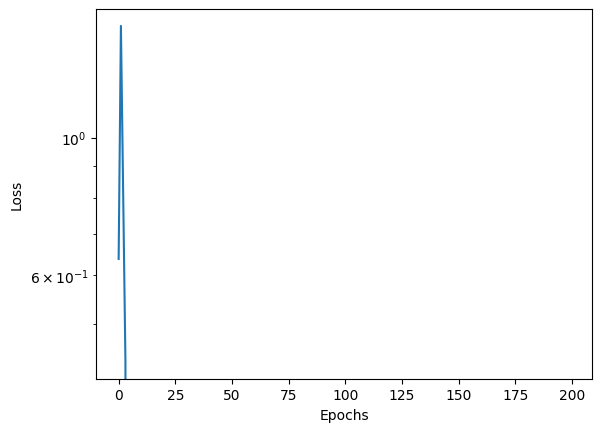

In [7]:

plt.plot(train_losses)
print(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()



tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

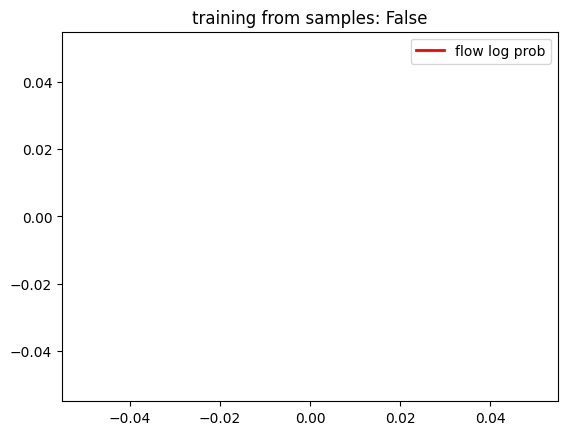

In [8]:

plt.figure()

# plot target
x_test = torch.linspace(-5, 5,steps = 100).reshape(-1,1)
# plt.plot(x_test, target_p(x_test), label = "target", color = "black")

# plot flow samples
z_samples = flow._distribution.sample(batch_size) 
x, _ = flow._transform(z_samples)  
# plt.hist(x.detach().cpu().numpy().reshape(-1,), bins = 40, density = True, label = "samples", color = "red", alpha = 0.5)

# plot flow log prob
z, dz_dx = flow._transform.inverse(x_test)  
px = (flow._distribution.log_prob(z) + dz_dx).exp()
print(x)
print(px)
plt.plot(x_test.detach().cpu().numpy(), px.detach().cpu().numpy(), label = "flow log prob", color = "red", lw = 2)

plt.legend()
plt.title("training from samples: "+str(train_from_samples))
plt.show()
